In [1]:
import os
import sys
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage.draw import disk, ellipsoid
from skimage.measure import label
from scipy import stats
from scipy.special import erf
from scipy.optimize import least_squares
from time import time
from numba import jit, njit, prange
from tqdm.notebook import tqdm
# from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from datetime import timedelta

In [2]:
src_path = '../src'
sys.path.append(src_path)
from Lib import tk_breakpoint

In [3]:
class lstq_Model:
    def __init__(self, nfev):
        pass

    @staticmethod
    @njit(parallel=True)
    def jac_gauss3D(coeffs, data, z, y, x, num_spots, num_coeffs, const=0):
        # Gradient ((m,n) Jacobian matrix):
        # grad[i,j] = derivative of f[i] wrt coeffs[j]
        # e.g. m data points with n coeffs --> grad with m rows and n col
        grad = np.empty((len(z), num_coeffs*num_spots))
        ns = np.arange(0,num_coeffs*num_spots,num_coeffs)
        for i in prange(num_spots):
            n = ns[i]
            coeffs_i = coeffs[n:n+num_coeffs]
            z0, y0, x0, sz, sy, sx, A, B = coeffs_i
            # Center rotation around peak center
            zc = z - z0
            yc = y - y0
            xc = x - x0
            # Build 3D gaussian by multiplying each 1D gaussian function
            g_x = np.exp(-(xc**2)/(2*(sx**2)))
            g_y = np.exp(-(yc**2)/(2*(sy**2)))
            g_z = np.exp(-(zc**2)/(2*(sz**2)))
            g = g_x*g_y*g_z
            grad[:,n] = g * 2*zc / (2*(sz**2)) # wrt zc
            grad[:,n+1] = g * 2*yc / (2*(sy**2)) # wrt yc
            grad[:,n+2] = g * 2*xc / (2*(sx**2)) # wrt xc
            grad[:,n+3] = g * zc**2 / (sz**3) # wrt sz
            grad[:,n+4] = g * yc**2 / (sy**3) # wrt sy
            grad[:,n+5] = g * xc**2 / (sx**3) # wrt sx
            grad[:,n+6] = g # wrt A
            grad[:,n+7] = np.ones(len(x)) # wrt B
        return -grad

    @staticmethod
    @njit(parallel=False)
    def _gauss3D(z, y, x, coeffs, num_spots, num_coeffs, const):
        model = np.zeros(len(z))
        n = 0
        for i in range(num_spots):
            coeffs_i = coeffs[n:n+num_coeffs]
            z0, y0, x0, sz, sy, sx, A, B = coeffs_i
            # Center rotation around peak center
            zc = z - z0
            yc = y - y0
            xc = x - x0
            # Build 3D gaussian by multiplying each 1D gaussian function
            gauss_x = np.exp(-(xc**2)/(2*(sx**2)))
            gauss_y = np.exp(-(yc**2)/(2*(sy**2)))
            gauss_z = np.exp(-(zc**2)/(2*(sz**2)))
            model += A*gauss_x*gauss_y*gauss_z + B
            n += num_coeffs
        return model + const

    def gaussian_3D(self, z, y, x, coeffs):
        z0, y0, x0, sz, sy, sx, A, B = coeffs
        # Center rotation around peak center
        zc = z - z0
        yc = y - y0
        xc = x - x0
        # Build 3D gaussian by multiplying each 1D gaussian function
        gauss_x = np.exp(-(xc**2)/(2*(sx**2)))
        gauss_y = np.exp(-(yc**2)/(2*(sy**2)))
        gauss_z = np.exp(-(zc**2)/(2*(sz**2)))
        gauss = A*gauss_x*gauss_y*gauss_z + B
        return gauss

    def compute_const(self, z, y, x, const_coeffs):
        const = 0
        for const_c in const_coeffs:
            const += self.gaussian_3D(z, y, x, const_c)
        return const

    def residuals(self, coeffs, data, z, y, x, num_spots, num_coeffs, const=0):
        self.pbar.update(1)
        f = self._gauss3D
        return data - f(z, y, x, coeffs, num_spots, num_coeffs, const)

    def goodness_of_fit(self, y_obs, y_model, ddof):
        chisq, p_chisq = stats.chisquare(y_obs, y_model,
                                         ddof=ddof)
        y_mean = y_obs.mean()
        # Sum of squared errors
        SSE = np.sum(np.square(y_obs-y_model))
        # Total sum of squares
        SST = np.sum(np.square(y_obs-y_mean))
        # NOTE: R-square is valid ONLY for linear regressions
        R_sq = 1 - (SSE/SST)
        # Degree of freedom
        N = len(y_obs)
        dof = N-ddof
        # Adjusted R squared
        adj_Rsq = 1 - (((1-R_sq)*(N-1))/(N-ddof-1))
        # Root mean squared error (a.k.a "standard error of the regression")
        RMSE = np.sqrt(SSE/dof)
        # Normalized mean squared error
        NRMSE = RMSE/y_mean
        # Frank relative NRMSE (i.e. NRMSE normalized to 0,1 with 1 being perfect fit)
        F_NRMSE = 2/(1+np.exp(NRMSE))
        # Kolmogorov–Smirnov test
        ks, p_ks = stats.ks_2samp(y_obs, y_model)
        return chisq, p_chisq, R_sq, RMSE, ks, p_ks, adj_Rsq, NRMSE, F_NRMSE
    
    def get_bounds_init_guess(self, num_spots_s, num_coeffs, zyx_centers,
                              spots_radii_pxl_s, spots_max_A_s, spots_Bs_guess):

        low_limit = np.zeros(num_spots_s*num_coeffs)
        high_limit = np.zeros(num_spots_s*num_coeffs)
        init_guess_s = np.zeros(num_spots_s*num_coeffs)
        n = 0
        # center bounds limit
        xy_cbl = 5
        z_cbl = 0.5
        input = zip(zyx_centers, spots_radii_pxl_s,
                    spots_max_A_s, spots_Bs_guess)
        for zyx_c, spot_radii, A_guess, B_guess in input:
            z0, y0, x0 = zyx_c
            c, b, a = spot_radii
            # z0, y0, x0, sz, sy, sx, A, B = coeffs
            low_lim = np.array([z0-z_cbl, y0-xy_cbl, x0-xy_cbl,
                                 -c*2, -b*2, -a*2,      1,      0])
            high_lim = np.array([z0+z_cbl, y0+xy_cbl, x0+xy_cbl,
                                c*2, b*2, a*2, np.inf, np.inf])
            guess = np.array([z0, y0, x0, c, b, a, A_guess, B_guess])
            low_limit[n:n+num_coeffs] = low_lim
            high_limit[n:n+num_coeffs] = high_lim
            init_guess_s[n:n+num_coeffs] = guess
            n += num_coeffs
        bounds = (low_limit, high_limit)
        return bounds, init_guess_s
    
    def integrate(self, zyx_centers, zyx_sigmas, A, B, 
                  sum_obs=0, lower_bounds=None, upper_bounds=None, 
                  verbose=0):
        """Integrate Gaussian peaks with erf function.

        Parameters
        ----------
        zyx_centers : (3,) ndarray
            [zc, yc, xc] ndarray centre coordinates of the peak
        zyx_sigmas : (3,) ndarray
            [zs, ys, xs] ndarray sigmas of the peak.
        A : float
            Amplitude of the peak
        B : float
            Background level of the peak
        lower_bounds : ndarray
            [z, y, x] lower bounds of the integration volume. If None the
            lower bounds will be equal to -1.96*zyx_sigmas (95%)
        upper_bounds : ndarray
            [z, y, x] upper bounds of the integration volume. If None the
            upper bounds will be equal to 1.96*zyx_sigmas (95%)
        sum_obs: float
            Printed alongside with the returned I_tot is verbose==3. Used for
            debugging to check that sum_obs and I_tot are in the same order
            of magnitude.
            

        Returns
        -------
        I_tot: float
            Result of the total integration.
        I_foregr: float
            Result of foregroung integration (i.e. background subtracted).

        """
        # Center gaussian to peak center coords
        if lower_bounds is None:
            # Use 95% of peak as integration volume    
            zyx_c1 = -1.96 * zyx_sigmas
        else:      
            zyx_c1 = lower_bounds - zyx_center
        if upper_bounds is None:
            zyx_c2 = 1.96 * zyx_sigmas
        else:
            zyx_c2 = upper_bounds - zyx_center

        # Substitute variable x --> t to apply erf
        t_z1, t_y1, t_x1 = zyx_c1 / (np.sqrt(2)*zyx_sigmas)
        t_z2, t_y2, t_x2 = zyx_c2 / (np.sqrt(2)*zyx_sigmas)
        s_tz, s_ty, s_tx = (zyx_sigmas) * np.sqrt(np.pi/2)
        D_erf_z = erf(t_z2)-erf(t_z1)
        D_erf_y = erf(t_y2)-erf(t_y1)
        D_erf_x = erf(t_x2)-erf(t_x1)
        I_foregr = A * s_tz*s_ty*s_tx * D_erf_z*D_erf_y*D_erf_x
        I_tot = I_foregr + B*np.prod(zyx_c2-zyx_c2)
        if verbose==3:
            print('--------------')
            print(f'Total integral result, observed sum = {I_tot}, {sum_obs}')
            print(f'Foregroung integral values: {I_foregr}')
            print('--------------')
        return I_tot, I_foregr

In [4]:
# bp = tk_breakpoint()

# User inputs
verbose = 1
zvd, yvd, xvd = [0.35, 0.0672498, 0.0672498]
pos_path = ('G:/My Drive/1_MIA_Data/Anika/WTs/SCGE/Diploids'
            '/2020-04-27_SCGE_Diploid_3/2020-27-04_ASY15_SCGE_60nM/'
            'TIFFs/Position_15')
h5_filename = '1_4_p-_ellip_nucleoQUANT_test_data_v1.h5'
img_filename = 'ASY15-1_60nM-15_s15_mNeon_processed.npy'

cell_ID = 1

In [5]:
# Load data
num_cpu = multiprocessing.cpu_count()
print('Loading data...')
images_path = os.path.join(pos_path, 'Images')
mitoQ_path = os.path.join(pos_path, 'NucleoData')
h5_path = os.path.join(mitoQ_path, h5_filename)
img_path = os.path.join(images_path, img_filename)

img = np.load(img_path)

df_h5 = pd.read_hdf(h5_path, '/frame_0')
df_h5 = df_h5.loc[cell_ID]

num_spots = len(df_h5)
spots_centers = df_h5[['z', 'y', 'x']].to_numpy()
spots_radii_um = df_h5[['z radius (µm)',
                        'xy radius (µm)',
                        'xy radius (µm)']].to_numpy()

spots_max_As = df_h5['vox mNeon (uint8)'].to_numpy()
ids = df_h5.index.to_numpy()
print('Data successfully loaded.')

Loading data...
Data successfully loaded.


In [6]:
# Build nucleoids 4D labels
print('Building mask...')
spots_radii_pxl = np.zeros_like(spots_radii_um)
# z0, y0, x0, sz, sy, sx, A, B = coeffs
num_coeffs = 8
spots_3Dmask = np.zeros(img.shape, bool)
spots_4D_lab = np.zeros((num_spots,*img.shape), int)
Bs_guess = np.zeros(num_spots)
Z, Y, X = spots_3Dmask.shape
z, y, x = np.ogrid[0:Z, 0:Y, 0:X]
input = enumerate(zip(ids, spots_centers, spots_radii_um))
for i, (id, z0y0x0, zs_xys) in input:
    z0, y0, x0 = z0y0x0
    zs, xys, _ = zs_xys
    a = xys/yvd
    c = zs/zvd
    spots_radii_pxl[i] = [c, a, a]
    sph_mask = (
                  ((x-x0)**2/(a**2))
                + ((y-y0)**2/(a**2))
                + ((z-z0)**2/(c**2))
                ) <= 1
    spots_3Dmask[sph_mask] = sph_mask[sph_mask]
    spots_4D_lab[i, sph_mask] = id

    # Get B_guess as the 25 percentile of the spheroid outer surface intensities
    if c<1:
        # Sinze z radius is one the spheroid is a circle on the z0 slice
        inner_sph = (
                      ((x-xc)**2
                     + (y-yc)**2)
                     ) < (a-1)**2
        surf_sph_mask = np.ones(img.shape, bool)
        mask_s1[z0] = inner_sph[0]
    else:
        inner_sph = (
                          ((x-x0)**2/((a-1)**2))
                        + ((y-y0)**2/((a-1)**2))
                        + ((z-z0)**2/((c-1)**2))
                        ) <= 1
    surf_sph_mask = mask = np.logical_xor(sph_mask, inner_sph)
    B_guess = np.quantile(img[surf_sph_mask], 0.25)
    Bs_guess[i] = B_guess
    # Test B_guess
    # B_guess_img = np.zeros_like(img)
    # B_guess_img[surf_sph_mask] = img[surf_sph_mask]
    # spot_img = np.zeros_like(img)
    # spot_img[sph_mask] = img[sph_mask]
    # print(B_guess)
    # fig, ax = plt.subplots(1,2)
    # ax[0].imshow(B_guess_img[z0])
    # ax[1].imshow(spot_img[z0])
    # plt.show()



# Label 4D lab to get connected nucleoids in the 3D space
spots_3D_lab = label(spots_4D_lab.max(axis=0).astype(bool))
print('Masks built successfully.')

Building mask...
Masks built successfully.


In [7]:
class intersect_neigh_idx_s:
    def __init__(self, spots_4D_lab):
        self.spots_4D_mask = spots_4D_lab>0
        self.spots_4D_lab = spots_4D_lab

    def eval(self, s):
        spot_id_lab = self.spots_4D_lab[s]
        spot_id_mask = spot_id_lab>0

        obj_id = spots_3D_lab[spot_id_mask][0]
        obj_mask = spots_3D_lab==obj_id

        intersecting_idx = [s0 for s0, spot_mask in enumerate(self.spots_4D_mask)
                            if spot_mask[spot_id_mask].any()]

        neigh_idx = [s0 for s0, spot_mask in enumerate(self.spots_4D_mask)
                            if spot_mask[obj_mask].any()]

        return intersecting_idx, neigh_idx, obj_id

# Get number of intersections for each spot
print('Computing intersections...')
t0 = time()
intersect_neigh = intersect_neigh_idx_s(spots_4D_lab)
with ThreadPoolExecutor(num_cpu) as ex:
    result = ex.map(intersect_neigh.eval, range(num_spots))

itersecting_idx_li = []
neigh_idx_li = []
num_intersect = []
obj_ids = []
num_neigh = []
for intersect_idx, neigh_idx, obj_id in result:
    itersecting_idx_li.append(intersect_idx)
    neigh_idx_li.append(neigh_idx)
    num_intersect.append(len(intersect_idx))
    num_neigh.append(len(neigh_idx))
    obj_ids.append(obj_id)

df_intersect = pd.DataFrame({'id': ids,
                             'obj_id': obj_ids,
                             'num_intersect': num_intersect,
                             'num_neigh': num_neigh,
                             'intersecting_idx': itersecting_idx_li,
                             'neigh_idx': neigh_idx_li}
                             ).sort_values('num_intersect')
df_intersect.index.name = 's'
t1 = time()
print(f'Intersections computed in {t1-t0:.2f} s!')

Computing intersections...
Intersections computed in 2.53 s!


In [8]:
# Iterate spots in number of neighboring spots ascending order
t0_opt = time()
init_guess_li = [None]*num_spots
fitted_coeffs = [[] for _ in range(num_spots)]
all_intersect_fitted_bool = [False]*num_spots
iter = zip(df_intersect.index,
           df_intersect['intersecting_idx'],
           df_intersect['neigh_idx'])
for count, (s, intersect_idx, neigh_idx) in enumerate(iter):
    # Get the fitted coeffs of the intersecting peaks
    intersect_coeffs = [fitted_coeffs[i] for i in intersect_idx]
    if verbose == 2:
        print('-----------')
        print(f'Current spot idx: {s}')
        print(f'Neighbours indices of current spot: {intersect_idx}')
    all_intersect_fitted = all(intersect_coeffs)
    if not all_intersect_fitted:
        if verbose == 2:
            print(f'Intersect. coeffs: {intersect_coeffs}')
        # Set coeffs of already fitted neighbours as model constants
        non_inters_neigh_idx = [s for s in neigh_idx if s not in intersect_idx]
        if verbose == 2:
            print(f'Fitted bool: {all_intersect_fitted_bool}')
            print(f'Non-intersecting neighbours idx: {non_inters_neigh_idx}')
        neigh_fitted_coeffs = [fitted_coeffs[i] for i in non_inters_neigh_idx
                                                if all_intersect_fitted_bool[i]]
        neigh_fitted_idx = [i for i in non_inters_neigh_idx
                                    if all_intersect_fitted_bool[i]]
        if verbose == 2:
            print('All-neighbours-fitted coeffs (model constants): '
                  f'{neigh_fitted_coeffs}')
        # Use not completely fitted neigh coeffs as initial guess
        not_all_intersect_fitted_coeffs = [
                                       fitted_coeffs[i]
                                       for i in intersect_idx
                                       if not all_intersect_fitted_bool[i]]
        if verbose == 2:
            print('Not-all-neighbours-fitted coeffs (model initial guess): '
                  f'{not_all_intersect_fitted_coeffs}')
        # Fit n intersecting spots as sum of n gaussian + model constants
        fit_idx = intersect_idx
        num_spots_s = len(fit_idx)
        zyx_centers = [None]*num_spots_s
        spots_radii_pxl_s = [None]*num_spots_s
        spots_max_A_s = [None]*num_spots_s
        spots_Bs_guess = [None]*num_spots_s
        for k, i in enumerate(fit_idx):
            zyx_centers[k] = tuple(spots_centers[i])
            spots_radii_pxl_s[k] = spots_radii_pxl[i]
            spots_max_A_s[k] = spots_max_As[i]
            spots_Bs_guess[k] = Bs_guess[i]
        if verbose == 2:
            print(f'Fitting spot idx: {fit_idx}, '
                  f'with centers {zyx_centers}')
        # Fit multipeaks
        fit_spots_4D_lab = spots_4D_lab[fit_idx]
        z, y, x = np.nonzero(fit_spots_4D_lab.max(axis=0))
        data_s = img[z,y,x]
        model = lstq_Model(100*len(z))
        # Get constants
        if neigh_fitted_idx:
            # # Testing
            # print(f'Current spot idx: {s}')
            # print(f'Fitting spots idx: {fit_idx}')
            # print(f'Fitted neigh idx: {neigh_fitted_idx}')
            # check_all_neigh = all([fitted_coeffs[i] for i in neigh_fitted_idx])
            # print(f'Are the fitted neigh spots really fitted? {check_all_neigh}')
            # obj_3D_lab = spots_4D_lab[neigh_idx].max(axis=0)
            # neigh_fitted_3D_lab = spots_4D_lab[neigh_fitted_idx].max(axis=0)
            # fitting_3D_lab = spots_4D_lab[fit_idx].max(axis=0)
            # obj_img = np.zeros_like(img)
            # obj_img[obj_3D_lab>0] = img[obj_3D_lab>0]
            # neigh_fitted_img = np.zeros_like(img)
            # z_neigh, y_neigh, x_neigh = np.nonzero(neigh_fitted_3D_lab)
            # neight_fitted_const = model.compute_const(
            #                                    z_neigh, y_neigh, x_neigh,
            #                                    neigh_fitted_coeffs)
            # neigh_fitted_img[z_neigh, y_neigh, x_neigh] = neight_fitted_const
            #
            # neigh_fit_img = np.zeros_like(img)
            # neigh_fit_img[neigh_fitted_3D_lab>0] = img[neigh_fitted_3D_lab>0]
            #
            # fitting_img = np.zeros_like(img)
            # fitting_img[fitting_3D_lab>0] = img[fitting_3D_lab>0]
            # fig, ax = plt.subplots(2,3, sharex=True, sharey=True)
            # ax = ax.flatten()
            # ax[0].imshow(obj_3D_lab.max(axis=0))
            # ax[0].set_title('Object label')
            #
            # ax[1].imshow(neigh_fitted_3D_lab.max(axis=0))
            # ax[1].set_title('Fitted neighbour label')
            #
            # ax[2].imshow(fitting_3D_lab.max(axis=0))
            # ax[2].set_title('Fitting label')
            #
            # ax[3].imshow(obj_img.max(axis=0))
            # ax[3].set_title('Object image')
            #
            # ax[4].imshow(neigh_fitted_img.max(axis=0), vmax=obj_img.max())
            # ax[4].set_title('Neigh fitted data')
            #
            # ax[5].imshow(neigh_fit_img.max(axis=0), vmax=obj_img.max())
            # ax[5].set_title('Neigh fitted image')
            # plt.show()
            # # End of test

            const = model.compute_const(z,y,x, neigh_fitted_coeffs)
        else:
            const = 0
        # test this https://cars9.uchicago.edu/software/python/lmfit/examples/example_reduce_fcn.html#sphx-glr-examples-example-reduce-fcn-py
        bounds, init_guess_s = model.get_bounds_init_guess(
                                                 num_spots_s, num_coeffs,
                                                 zyx_centers, spots_radii_pxl_s,
                                                 spots_max_A_s, spots_Bs_guess
        )
        bar_f = '{desc:<25}{percentage:3.0f}%|{bar:40}{r_bar}'
        model.pbar = tqdm(desc=f'Fitting spot {s} ({count+1}/{num_spots})',
                          total=100*len(z), unit=' fev',
                          position=0, leave=True)
        leastsq_result = least_squares(model.residuals, init_guess_s,
                                       args=(data_s, z, y, x, num_spots_s,
                                             num_coeffs),
                                       # jac=model.jac_gauss3D,
                                       kwargs={'const': const},
                                       loss='linear', f_scale=0.1,
                                       bounds=bounds)
        # model.pbar.update(100*len(z)-model.pbar.n)
        model.pbar.close()

        lstsq_x = leastsq_result.x.reshape((num_spots_s, num_coeffs))
        init_guess_s_2D = init_guess_s.reshape((num_spots_s, num_coeffs))
        # print(f'Fitted coeffs: {lstsq_x}')
        # Store already fitted peaks
        # NOTE: init_guess_li created only for testing purposes
        for i, s_fit in enumerate(fit_idx):
            fitted_coeffs[s_fit] = list(lstsq_x[i])
            init_guess_li[s_fit] = list(init_guess_s_2D[i])
        #     print(s_fit)
        #     print(i)
        #     print(fitted_coeffs[s_fit])
        #     print(init_guess_li[s_fit])
        #
        # print(s)
        # print(init_guess_s)
        # print(leastsq_result.x)

        # fig, ax = plt.subplots(1,3)
        # fit_data = model._gauss3D(z, y, x, leastsq_result.x, num_spots_s,
        #                           num_coeffs, 0)
        # img_fit = np.zeros_like(img)
        # img_fit[z,y,x] = fit_data
        # img_s = np.zeros_like(img)
        # img_s[z,y,x] = data_s
        # y_intens = img_s.max(axis=(0, 1))
        # y_intens = y_intens[y_intens!=0]
        # y_gauss = img_fit.max(axis=(0, 1))
        # y_gauss = y_gauss[y_gauss!=0]
        # ax[0].imshow(img_s.max(axis=0))
        # ax[1].imshow(img_fit.max(axis=0))
        # ax[2].scatter(range(len(y_intens)), y_intens)
        # ax[2].plot(range(len(y_intens)), y_gauss, c='r')
        # plt.show()
        # Check if now the fitted spots are fully fitted
        all_intersect_fitted = all([True if fitted_coeffs[i] else False
                                     for i in intersect_idx])
        if all_intersect_fitted:
            if verbose == 2:
                print(f'Fully fitted spot idx: {s}')
            all_intersect_fitted_bool[s] = True
    else:
        if verbose == 2:
            print(f'Fully fitted spot idx: {s}')
        all_intersect_fitted_bool[s] = True
        pbar = tqdm(desc=f'Spot done {count+1}/{num_spots}',
                          total=1, unit=' fev',
                          position=0, leave=True)
        pbar.update(1)
        pbar.close()
    if verbose == 2:
        print('-----------')

t1_opt = time()
exec_time = t1_opt-t0_opt
exec_time_delta = timedelta(seconds=exec_time)
print(f'Fitting process done in {exec_time_delta} HH:mm:ss')

Fitting spot 49 (1/50):   0%|          | 0/23500 [00:00<?, ? fev/s]

Fitting spot 17 (2/50):   0%|          | 0/58300 [00:00<?, ? fev/s]

Fitting spot 34 (3/50):   0%|          | 0/23500 [00:00<?, ? fev/s]

Fitting spot 35 (4/50):   0%|          | 0/23500 [00:00<?, ? fev/s]

Fitting spot 36 (5/50):   0%|          | 0/23500 [00:00<?, ? fev/s]

Fitting spot 27 (6/50):   0%|          | 0/39100 [00:00<?, ? fev/s]

Fitting spot 38 (7/50):   0%|          | 0/23500 [00:00<?, ? fev/s]

Fitting spot 39 (8/50):   0%|          | 0/23500 [00:00<?, ? fev/s]

Fitting spot 33 (9/50):   0%|          | 0/23500 [00:00<?, ? fev/s]

Fitting spot 30 (10/50):   0%|          | 0/23500 [00:00<?, ? fev/s]

Fitting spot 41 (11/50):   0%|          | 0/23500 [00:00<?, ? fev/s]

Fitting spot 29 (12/50):   0%|          | 0/23500 [00:00<?, ? fev/s]

Fitting spot 43 (13/50):   0%|          | 0/23500 [00:00<?, ? fev/s]

Fitting spot 28 (14/50):   0%|          | 0/39100 [00:00<?, ? fev/s]

Fitting spot 45 (15/50):   0%|          | 0/23500 [00:00<?, ? fev/s]

Fitting spot 48 (16/50):   0%|          | 0/23500 [00:00<?, ? fev/s]

Fitting spot 47 (17/50):   0%|          | 0/23500 [00:00<?, ? fev/s]

Fitting spot 40 (18/50):   0%|          | 0/23500 [00:00<?, ? fev/s]

Fitting spot 32 (19/50):   0%|          | 0/39100 [00:00<?, ? fev/s]

Fitting spot 31 (20/50):   0%|          | 0/62500 [00:00<?, ? fev/s]

Spot done 21/50:   0%|          | 0/1 [00:00<?, ? fev/s]

Fitting spot 9 (22/50):   0%|          | 0/139700 [00:00<?, ? fev/s]

Fitting spot 42 (23/50):   0%|          | 0/46700 [00:00<?, ? fev/s]

Fitting spot 46 (24/50):   0%|          | 0/46800 [00:00<?, ? fev/s]

Fitting spot 12 (25/50):   0%|          | 0/133200 [00:00<?, ? fev/s]

Spot done 26/50:   0%|          | 0/1 [00:00<?, ? fev/s]

Spot done 27/50:   0%|          | 0/1 [00:00<?, ? fev/s]

Fitting spot 24 (28/50):   0%|          | 0/296200 [00:00<?, ? fev/s]

Fitting spot 23 (29/50):   0%|          | 0/167800 [00:00<?, ? fev/s]

Fitting spot 22 (30/50):   0%|          | 0/222600 [00:00<?, ? fev/s]

Fitting spot 7 (31/50):   0%|          | 0/223900 [00:00<?, ? fev/s]

Fitting spot 10 (32/50):   0%|          | 0/288700 [00:00<?, ? fev/s]

Fitting spot 21 (33/50):   0%|          | 0/274700 [00:00<?, ? fev/s]

Spot done 34/50:   0%|          | 0/1 [00:00<?, ? fev/s]

Fitting spot 8 (35/50):   0%|          | 0/432400 [00:00<?, ? fev/s]

Fitting spot 4 (36/50):   0%|          | 0/568900 [00:00<?, ? fev/s]

Spot done 37/50:   0%|          | 0/1 [00:00<?, ? fev/s]

Spot done 38/50:   0%|          | 0/1 [00:00<?, ? fev/s]

Fitting spot 13 (39/50):   0%|          | 0/582400 [00:00<?, ? fev/s]

Spot done 40/50:   0%|          | 0/1 [00:00<?, ? fev/s]

Spot done 41/50:   0%|          | 0/1 [00:00<?, ? fev/s]

Spot done 42/50:   0%|          | 0/1 [00:00<?, ? fev/s]

Spot done 43/50:   0%|          | 0/1 [00:00<?, ? fev/s]

Spot done 44/50:   0%|          | 0/1 [00:00<?, ? fev/s]

Spot done 45/50:   0%|          | 0/1 [00:00<?, ? fev/s]

Spot done 46/50:   0%|          | 0/1 [00:00<?, ? fev/s]

Spot done 47/50:   0%|          | 0/1 [00:00<?, ? fev/s]

Spot done 48/50:   0%|          | 0/1 [00:00<?, ? fev/s]

Spot done 49/50:   0%|          | 0/1 [00:00<?, ? fev/s]

Spot done 50/50:   0%|          | 0/1 [00:00<?, ? fev/s]

Fitting process done in 0:01:25.495907 HH:mm:ss


In [67]:
class model_temp:
    def integrate(self, zyx_centers, zyx_sigmas, A, B, 
                      sum_obs=0, lower_bounds=None, upper_bounds=None, 
                      verbose=0):
            """Integrate Gaussian peaks with erf function.

            Parameters
            ----------
            zyx_centers : (3,) ndarray
                [zc, yc, xc] ndarray centre coordinates of the peak
            zyx_sigmas : (3,) ndarray
                [zs, ys, xs] ndarray sigmas of the peak.
            A : float
                Amplitude of the peak
            B : float
                Background level of the peak
            lower_bounds : ndarray
                [z, y, x] lower bounds of the integration volume. If None the
                lower bounds will be equal to -1.96*zyx_sigmas (95%)
            upper_bounds : ndarray
                [z, y, x] upper bounds of the integration volume. If None the
                upper bounds will be equal to 1.96*zyx_sigmas (95%)
            sum_obs: float
                Printed alongside with the returned I_tot is verbose==3. Used for
                debugging to check that sum_obs and I_tot are in the same order
                of magnitude.


            Returns
            -------
            I_tot: float
                Result of the total integration.
            I_foregr: float
                Result of foregroung integration (i.e. background subtracted).

            """
            # Center gaussian to peak center coords
            if lower_bounds is None:
                # Use 95% of peak as integration volume    
                zyx_c1 = -1.96 * zyx_sigmas
            else:      
                zyx_c1 = lower_bounds - zyx_center
            if upper_bounds is None:
                zyx_c2 = 1.96 * zyx_sigmas
            else:
                zyx_c2 = upper_bounds - zyx_center

            # Substitute variable x --> t to apply erf
            t_z1, t_y1, t_x1 = zyx_c1 / (np.sqrt(2)*zyx_sigmas)
            t_z2, t_y2, t_x2 = zyx_c2 / (np.sqrt(2)*zyx_sigmas)
            s_tz, s_ty, s_tx = (zyx_sigmas) * np.sqrt(np.pi/2)
            D_erf_z = erf(t_z2)-erf(t_z1)
            D_erf_y = erf(t_y2)-erf(t_y1)
            D_erf_x = erf(t_x2)-erf(t_x1)
            I_foregr = A * s_tz*s_ty*s_tx * D_erf_z*D_erf_y*D_erf_x
            I_tot = I_foregr + B*np.prod(zyx_c2-zyx_c1)
            if verbose==3:
                print('--------------')
                print(f'Total integral result, observed sum = {I_tot}, {sum_obs}')
                print(f'Foregroung integral values: {I_foregr}')
                print('--------------')
            return I_tot/255, I_foregr/255
        
    def store_metrics_good_spots(self, df_spotQUANT, obj_id, s,
                                 fitted_coeffs_s, I_tot, I_foregr):
        (z0_fit, y0_fit, x0_fit,
        sz_fit, sy_fit, sx_fit,
        A_fit, B_fit) = fitted_coeffs_s
        
        df_spotQUANT.at[(obj_id, s), 'z0_fit'] = z0_fit
        df_spotQUANT.at[(obj_id, s), 'y0_fit'] = y0_fit
        df_spotQUANT.at[(obj_id, s), 'x0_fit'] = x0_fit

        df_spotQUANT.at[(obj_id, s), 'sigma_z_fit'] = abs(sz_fit)
        df_spotQUANT.at[(obj_id, s), 'sigma_y_fit'] = abs(sy_fit)
        df_spotQUANT.at[(obj_id, s), 'sigma_x_fit'] = abs(sx_fit)
        
        df_spotQUANT.at[(obj_id, s), 'A_fit'] = A_fit
        df_spotQUANT.at[(obj_id, s), 'B_fit'] = B_fit
        
        df_spotQUANT.at[(obj_id, s), 'I_tot'] = I_tot
        df_spotQUANT.at[(obj_id, s), 'I_foregr'] = I_foregr

        df_spotQUANT.at[(obj_id, s), 'chisq'] = chisq
        df_spotQUANT.at[(obj_id, s), 'p_chisq'] = p_chisq

        df_spotQUANT.at[(obj_id, s), 'KS_stat'] = ks
        df_spotQUANT.at[(obj_id, s), 'p_KS'] = p_ks

        df_spotQUANT.at[(obj_id, s), 'RMSE'] = RMSE
        df_spotQUANT.at[(obj_id, s), 'NRMSE'] = NRMSE
        df_spotQUANT.at[(obj_id, s), 'F_NRMSE'] = F_NRMSE
        
        return df_spotQUANT
        

In [68]:
df_spotQUANT = df_intersect.reset_index(
                          ).set_index(['obj_id', 's'])

10.0 151.0 173.0
----------------------------
Image max = 188.35, spot max = 38.12
Neighbours idx = [49]
Spot idx = 49
Chisquare = 119.60, p = 1.0000
KS stat = 0.11, p = 0.1127
R_sq = 0.85, Adj. R-sq = 0.84
RMSE = 2.88
NRMSE = 0.16
F_NRMSE = 0.92
-------------------
Sigmas fit = (1.20, 2.01, 2.43)
A fit = 30.97, B fit = 8.67
Total integral result, fit sum, observed sum = 5522.41, 4143.99, 4143.99
Foregroung integral value: 2456.08
----------------------------


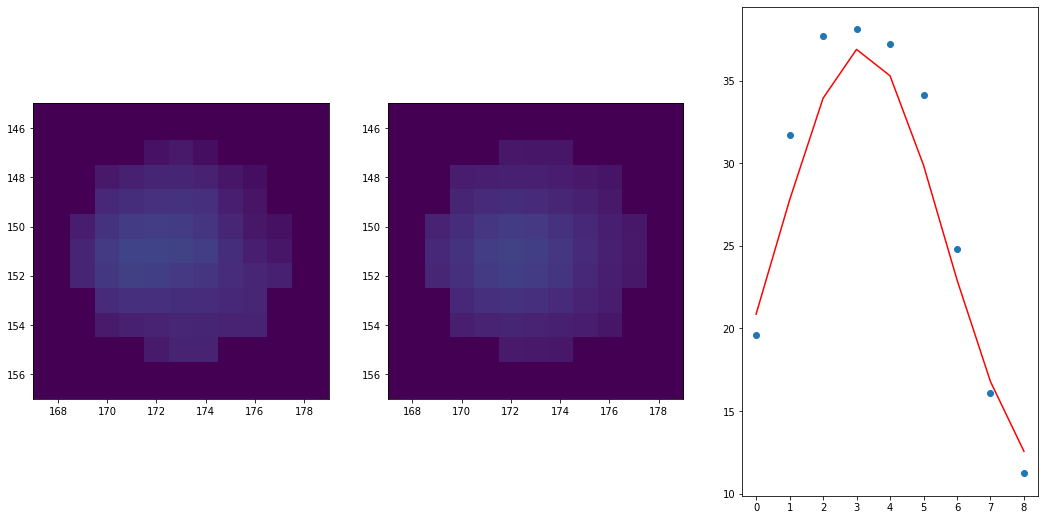

10.0 168.0 160.0
----------------------------
Image max = 188.35, spot max = 89.52
Neighbours idx = [28]
Spot idx = 28
Chisquare = 294.61, p = 0.9997
KS stat = 0.05, p = 0.6262
R_sq = 0.93, Adj. R-sq = 0.93
RMSE = 4.71
NRMSE = 0.15
F_NRMSE = 0.93
-------------------
Sigmas fit = (1.56, 2.10, 2.66)
A fit = 81.47, B fit = 8.80
Total integral result, fit sum, observed sum = 14178.92, 12256.24, 12256.24
Foregroung integral value: 9569.57
----------------------------


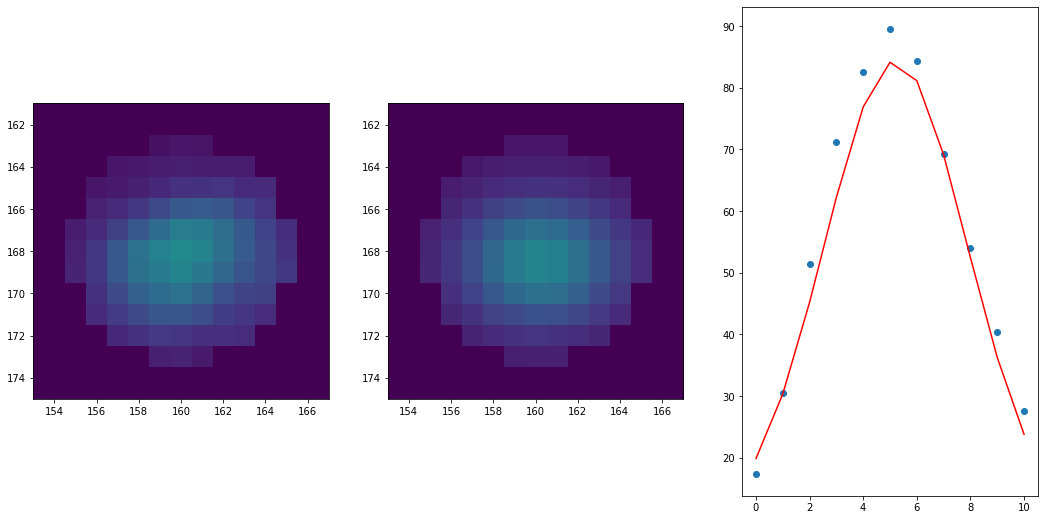

17.0 134.0 194.0
----------------------------
Image max = 188.35, spot max = 117.51
Neighbours idx = [9, 26, 31, 37, 39]
Spot idx = 9
Chisquare = 4165.86, p = 0.0000
KS stat = 0.17, p = 0.0000
R_sq = 0.73, Adj. R-sq = 0.73
RMSE = 13.15
NRMSE = 0.35
F_NRMSE = 0.83
-------------------
Sigmas fit = (1.43, 2.90, 4.18)
A fit = 101.59, B fit = 0.00
Total integral result, fit sum, observed sum = 23729.54, 30807.38, 30575.49
Foregroung integral value: 23729.54
----------------------------


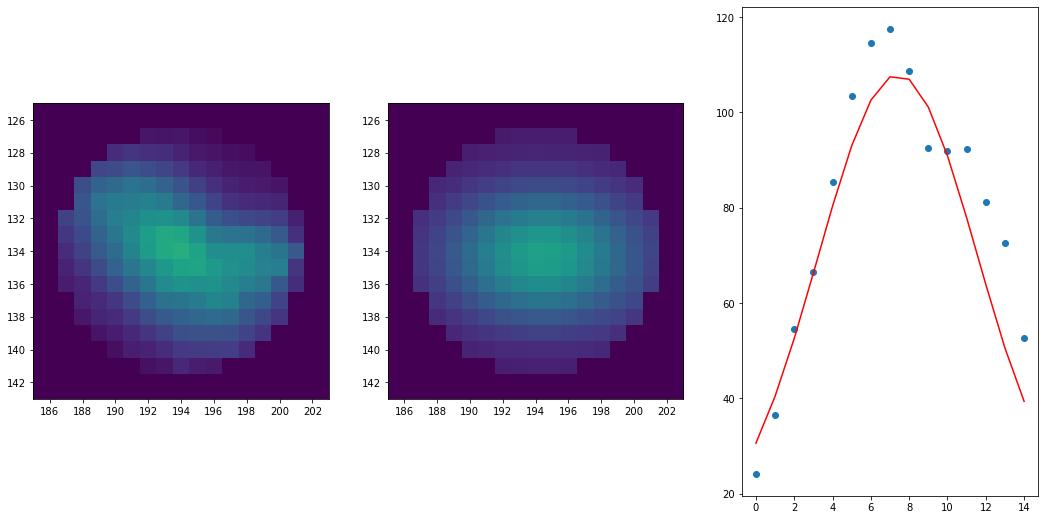

21.0 140.0 203.0
----------------------------
Image max = 188.35, spot max = 85.60
Neighbours idx = [9, 26, 31, 37, 39]
Spot idx = 26
Chisquare = 1589.78, p = 0.0000
KS stat = 0.13, p = 0.0001
R_sq = 0.74, Adj. R-sq = 0.73
RMSE = 9.35
NRMSE = 0.29
F_NRMSE = 0.86
-------------------
Sigmas fit = (1.42, 3.22, 3.49)
A fit = 69.78, B fit = 0.00
Total integral result, fit sum, observed sum = 15056.89, 19402.95, 19083.43
Foregroung integral value: 15056.89
----------------------------


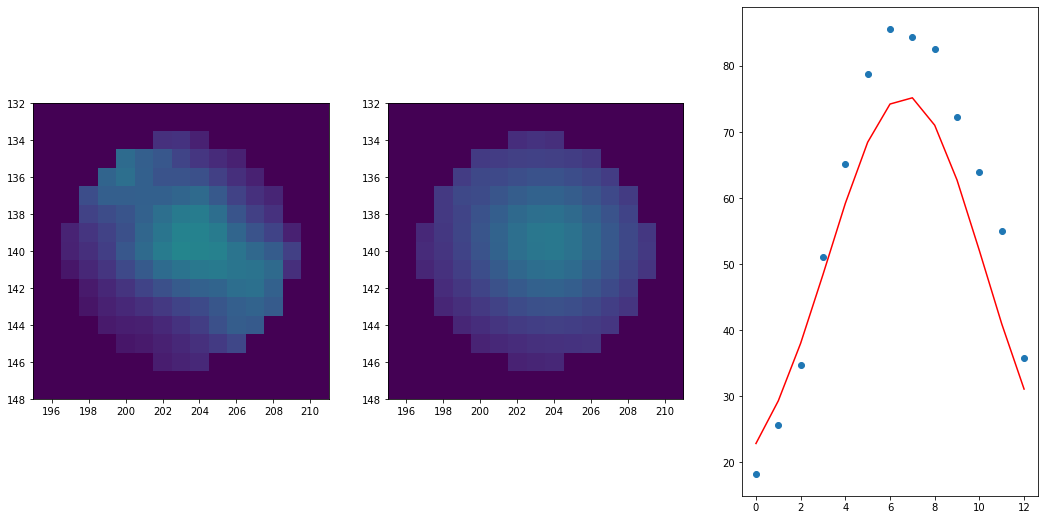

17.0 150.0 209.0
----------------------------
Image max = 188.35, spot max = 71.82
Neighbours idx = [9, 26, 31, 37, 39]
Spot idx = 31
Chisquare = 925.71, p = 0.0000
KS stat = 0.12, p = 0.0112
R_sq = 0.68, Adj. R-sq = 0.68
RMSE = 8.29
NRMSE = 0.28
F_NRMSE = 0.86
-------------------
Sigmas fit = (1.51, 3.47, 2.34)
A fit = 57.01, B fit = 0.00
Total integral result, fit sum, observed sum = 9423.12, 11783.20, 11719.85
Foregroung integral value: 9423.12
----------------------------


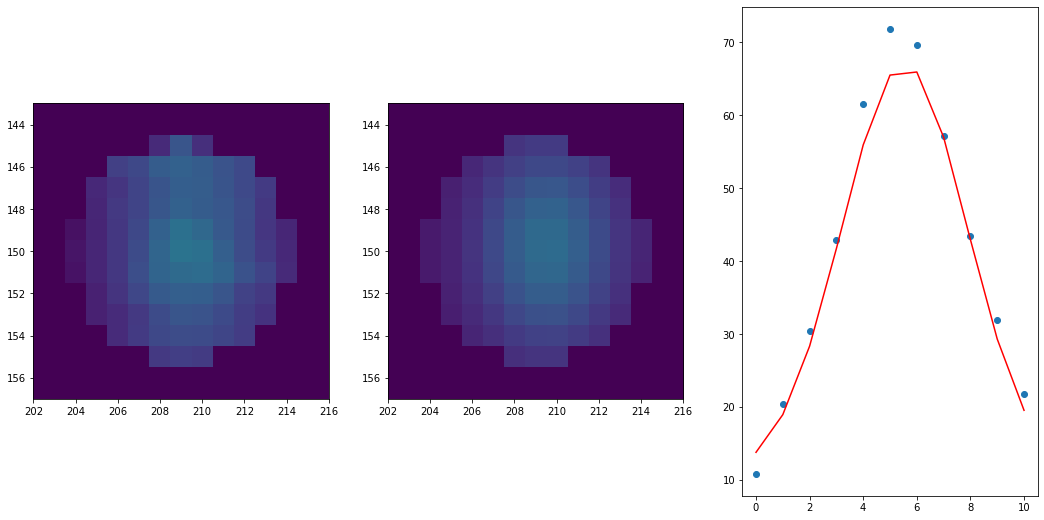

23.0 149.0 208.0
----------------------------
Image max = 188.35, spot max = 82.91
Neighbours idx = [9, 26, 31, 37, 39]
Spot idx = 37
Chisquare = 144.81, p = 1.0000
KS stat = 0.08, p = 0.4966
R_sq = 0.92, Adj. R-sq = 0.92
RMSE = 4.34
NRMSE = 0.14
F_NRMSE = 0.93
-------------------
Sigmas fit = (1.16, 2.28, 2.62)
A fit = 65.98, B fit = 0.00
Total integral result, fit sum, observed sum = 6193.14, 7394.35, 7246.94
Foregroung integral value: 6193.14
----------------------------


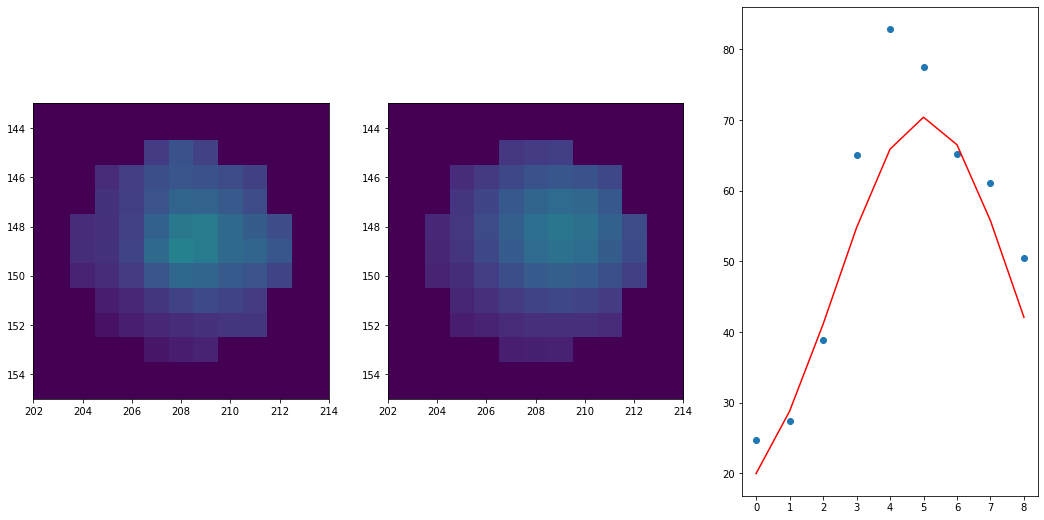

13.0 156.0 204.0
----------------------------
Image max = 188.35, spot max = 57.11
Neighbours idx = [9, 26, 31, 37, 39]
Spot idx = 39
Chisquare = 87.55, p = 1.0000
KS stat = 0.08, p = 0.4966
R_sq = 0.92, Adj. R-sq = 0.92
RMSE = 3.07
NRMSE = 0.11
F_NRMSE = 0.95
-------------------
Sigmas fit = (1.49, 1.96, 2.73)
A fit = 50.63, B fit = 10.33
Total integral result, fit sum, observed sum = 10398.16, 6740.01, 6698.98
Foregroung integral value: 5442.96
----------------------------


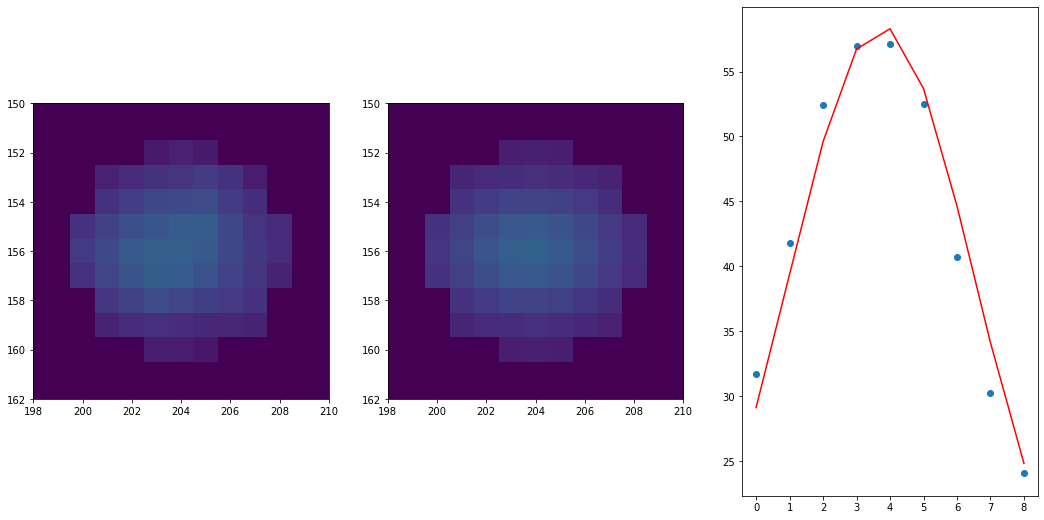

13.0 186.0 202.0
----------------------------
Image max = 188.35, spot max = 55.16
Neighbours idx = [35, 42, 44, 46]
Spot idx = 35
Chisquare = 138.14, p = 1.0000
KS stat = 0.10, p = 0.1725
R_sq = 0.85, Adj. R-sq = 0.84
RMSE = 4.31
NRMSE = 0.14
F_NRMSE = 0.93
-------------------
Sigmas fit = (1.74, 3.43, 2.87)
A fit = 52.64, B fit = 4.46
Total integral result, fit sum, observed sum = 16788.53, 7829.17, 7398.35
Foregroung integral value: 12183.64
----------------------------


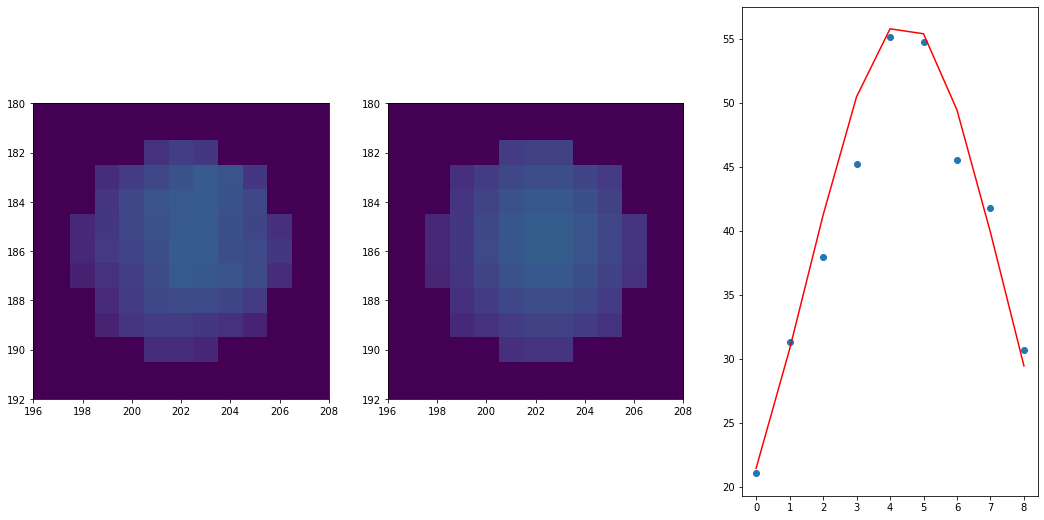

19.0 199.0 212.0
----------------------------
Image max = 188.35, spot max = 57.57
Neighbours idx = [35, 42, 44, 46]
Spot idx = 42
Chisquare = 407.31, p = 0.0000
KS stat = 0.10, p = 0.1725
R_sq = 0.70, Adj. R-sq = 0.69
RMSE = 6.37
NRMSE = 0.24
F_NRMSE = 0.88
-------------------
Sigmas fit = (1.29, 2.62, 2.86)
A fit = 47.27, B fit = 1.77
Total integral result, fit sum, observed sum = 7218.35, 5932.57, 6315.18
Foregroung integral value: 6187.16
----------------------------


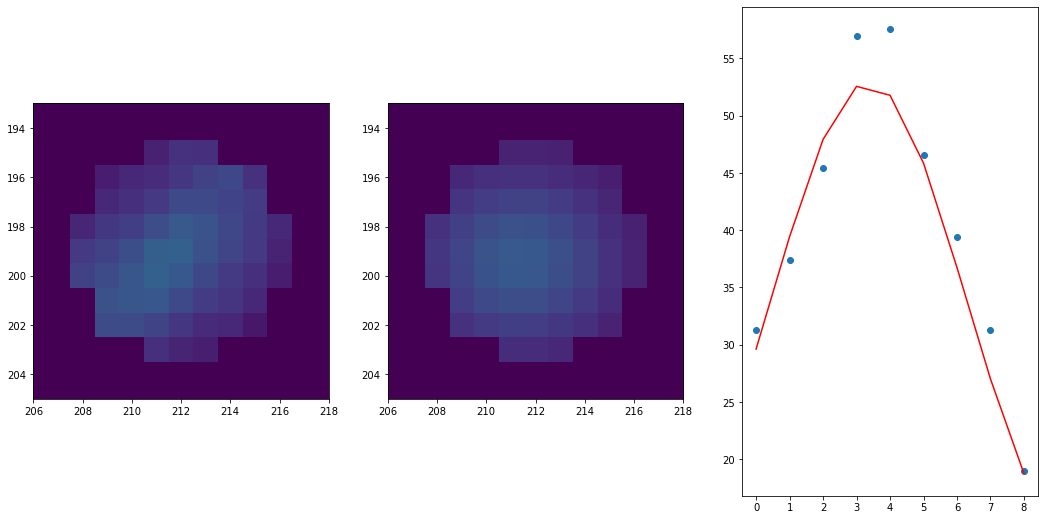

15.0 193.0 212.0
----------------------------
Image max = 188.35, spot max = 50.32
Neighbours idx = [35, 42, 44, 46]
Spot idx = 44
Chisquare = 253.20, p = 0.1034
KS stat = 0.09, p = 0.3630
R_sq = 0.72, Adj. R-sq = 0.71
RMSE = 4.89
NRMSE = 0.19
F_NRMSE = 0.90
-------------------
Sigmas fit = (1.71, 2.10, 3.84)
A fit = 36.54, B fit = 0.00
Total integral result, fit sum, observed sum = 6817.06, 5897.38, 5942.00
Foregroung integral value: 6817.06
----------------------------


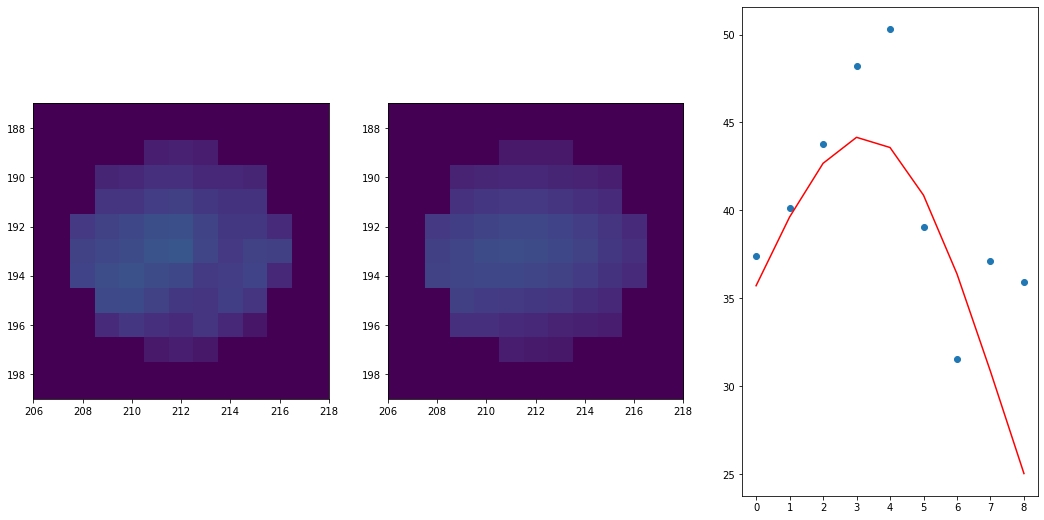

14.0 194.0 204.0
----------------------------
Image max = 188.35, spot max = 44.83
Neighbours idx = [35, 42, 44, 46]
Spot idx = 46
Chisquare = 99.70, p = 1.0000
KS stat = 0.11, p = 0.1127
R_sq = 0.87, Adj. R-sq = 0.86
RMSE = 3.21
NRMSE = 0.13
F_NRMSE = 0.93
-------------------
Sigmas fit = (1.44, 1.93, 3.92)
A fit = 35.46, B fit = 0.00
Total integral result, fit sum, observed sum = 5205.26, 5747.64, 5654.36
Foregroung integral value: 5205.26
----------------------------


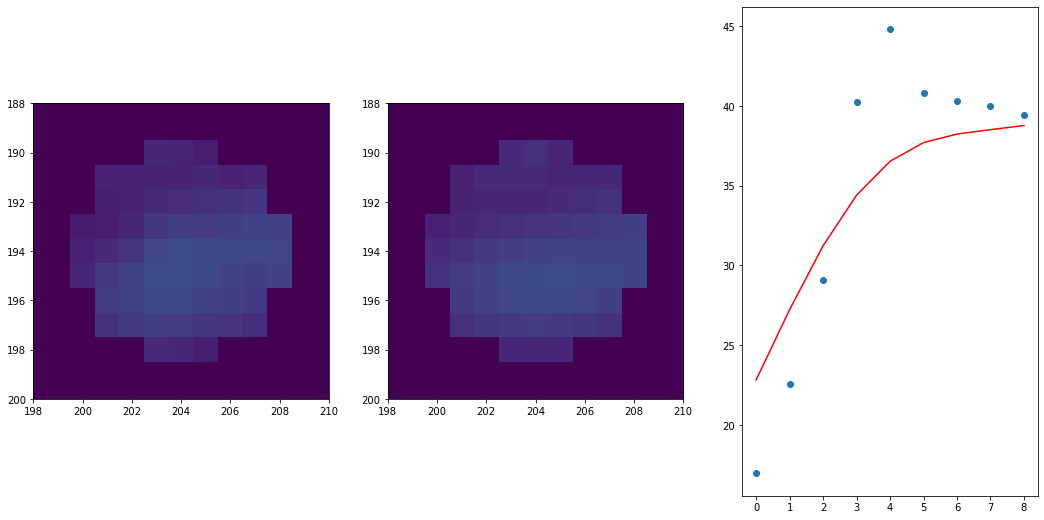

18.0 158.0 134.0
----------------------------
Image max = 188.35, spot max = 129.47
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 0
Chisquare = 4078.21, p = 0.0000
KS stat = 0.59, p = 0.0000
R_sq = -3.01, Adj. R-sq = -3.10
RMSE = 35.40
NRMSE = 0.44
F_NRMSE = 0.78
-------------------
Sigmas fit = (6.48, 3.50, 5.61)
A fit = 56.39, B fit = 0.00
Total integral result, fit sum, observed sum = 5205.26, 42520.85, 31424.26
Foregroung integral value: 5205.26
----------------------------


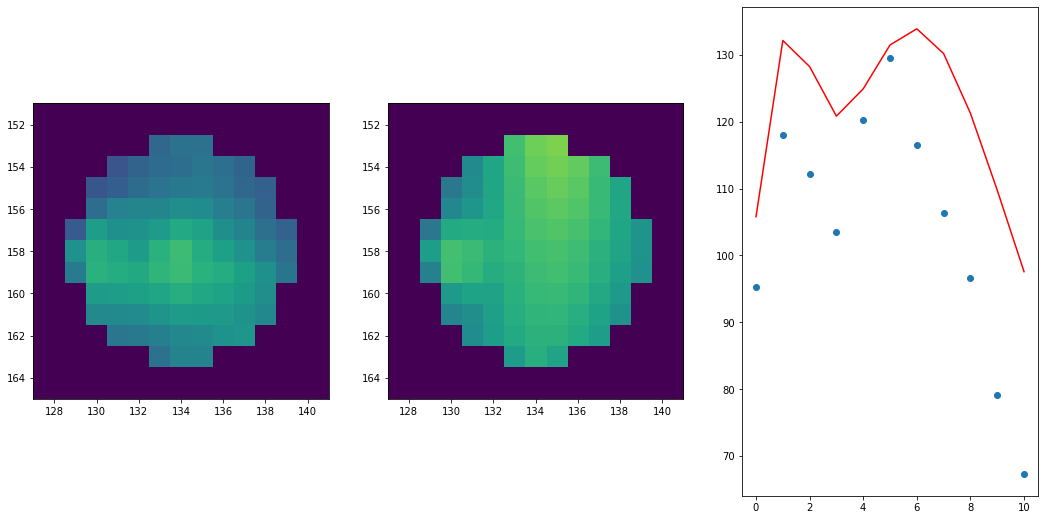

21.0 169.0 137.0
----------------------------
Image max = 188.35, spot max = 123.19
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 1
Chisquare = 6929.55, p = 0.0000
KS stat = 0.61, p = 0.0000
R_sq = -3.21, Adj. R-sq = -3.27
RMSE = 35.88
NRMSE = 0.52
F_NRMSE = 0.75
-------------------
Sigmas fit = (1.84, 3.53, 6.70)
A fit = 54.58, B fit = 0.00
Total integral result, fit sum, observed sum = 5205.26, 59770.63, 40435.05
Foregroung integral value: 5205.26
----------------------------


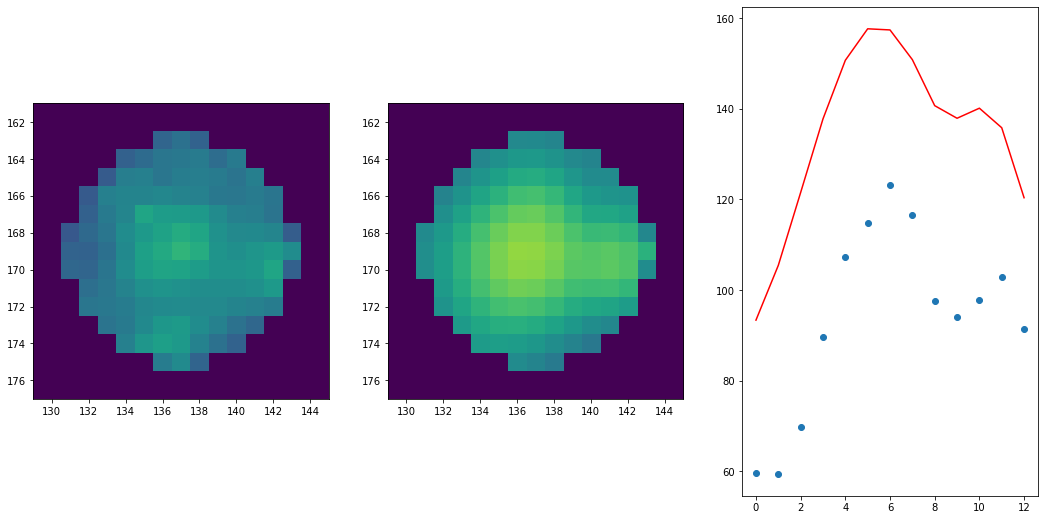

17.0 167.0 134.0
----------------------------
Image max = 188.35, spot max = 128.38
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 2
Chisquare = 4206.22, p = 0.0000
KS stat = 0.18, p = 0.0000
R_sq = 0.32, Adj. R-sq = 0.32
RMSE = 18.06
NRMSE = 0.29
F_NRMSE = 0.86
-------------------
Sigmas fit = (-1.48, 5.71, -3.99)
A fit = 81.99, B fit = 0.00
Total integral result, fit sum, observed sum = 37365.46, 78403.85, 67665.15
Foregroung integral value: 37365.46
----------------------------


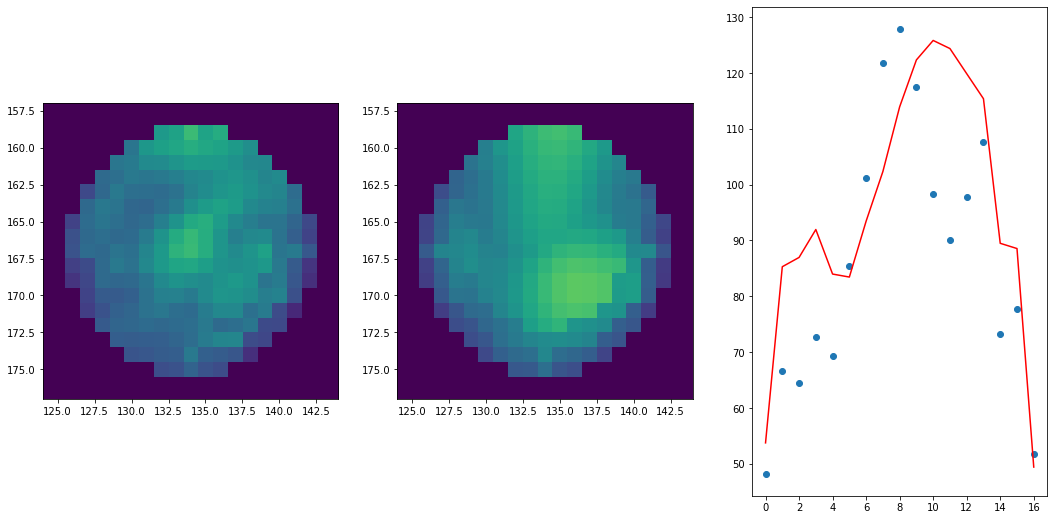

20.0 161.0 145.0
----------------------------
Image max = 188.35, spot max = 126.33
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 3
Chisquare = 10049.81, p = 0.0000
KS stat = 0.26, p = 0.0000
R_sq = 0.61, Adj. R-sq = 0.61
RMSE = 18.24
NRMSE = 0.43
F_NRMSE = 0.79
-------------------
Sigmas fit = (1.51, -2.86, -2.78)
A fit = 108.74, B fit = 0.00
Total integral result, fit sum, observed sum = 37365.46, 102179.75, 78890.65
Foregroung integral value: 37365.46
----------------------------


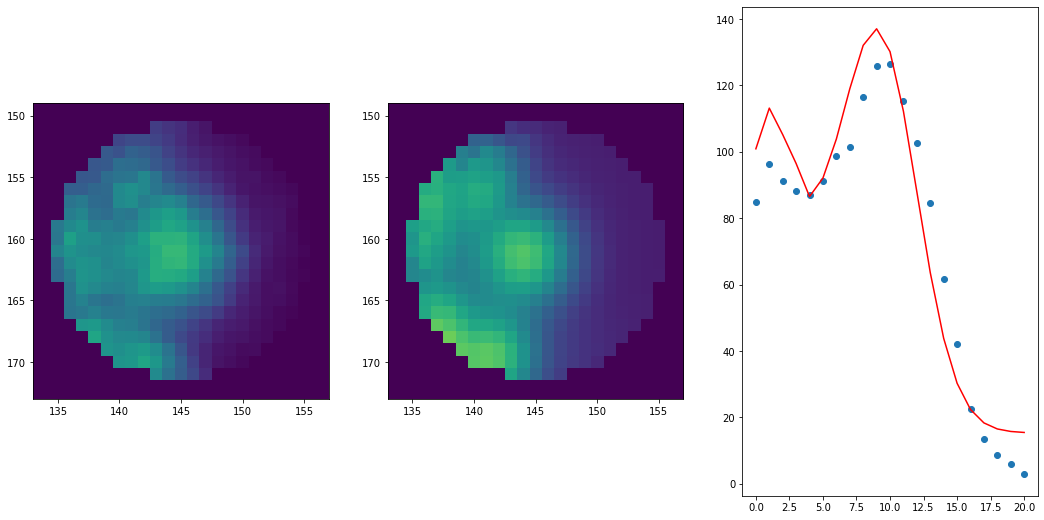

20.0 159.0 130.0
----------------------------
Image max = 188.35, spot max = 129.47
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 4
Chisquare = 1651.78, p = 0.0000
KS stat = 0.26, p = 0.0000
R_sq = 0.21, Adj. R-sq = 0.20
RMSE = 19.57
NRMSE = 0.29
F_NRMSE = 0.86
-------------------
Sigmas fit = (1.41, 1.91, 2.22)
A fit = 78.09, B fit = 0.00
Total integral result, fit sum, observed sum = 6320.89, 31871.78, 26195.53
Foregroung integral value: 6320.89
----------------------------


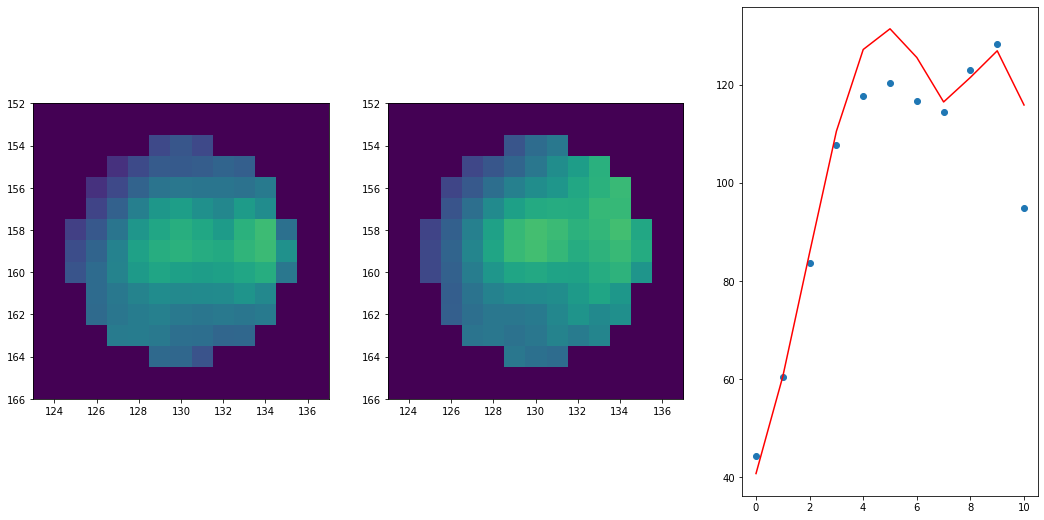

18.0 150.0 135.0
----------------------------
Image max = 188.35, spot max = 110.38
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 5
Chisquare = 5501.38, p = 0.0000
KS stat = 0.62, p = 0.0000
R_sq = -4.95, Adj. R-sq = -5.08
RMSE = 39.25
NRMSE = 0.64
F_NRMSE = 0.69
-------------------
Sigmas fit = (1.79, 3.35, 3.02)
A fit = 84.83, B fit = 0.00
Total integral result, fit sum, observed sum = 6320.89, 37717.38, 23948.62
Foregroung integral value: 6320.89
----------------------------


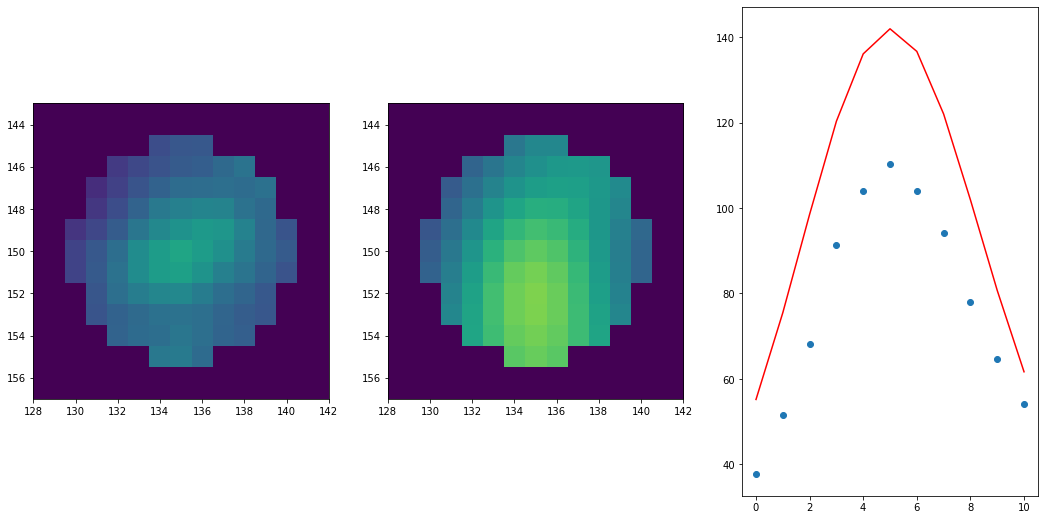

20.0 174.0 136.0
----------------------------
Image max = 188.35, spot max = 123.19
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 6
Chisquare = 3568.13, p = 0.0000
KS stat = 0.28, p = 0.0000
R_sq = -0.58, Adj. R-sq = -0.60
RMSE = 25.20
NRMSE = 0.41
F_NRMSE = 0.80
-------------------
Sigmas fit = (-1.61, 4.73, -3.87)
A fit = 73.93, B fit = 0.00
Total integral result, fit sum, observed sum = 6320.89, 46738.90, 35864.12
Foregroung integral value: 6320.89
----------------------------


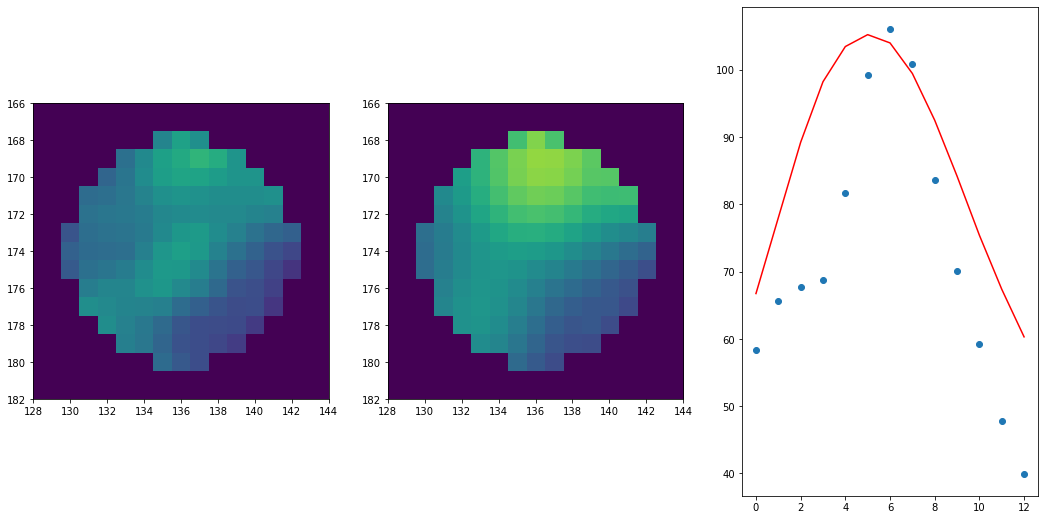

17.0 134.0 146.0
----------------------------
Image max = 188.35, spot max = 127.62
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 7
Chisquare = 1766.52, p = 0.0000
KS stat = 0.23, p = 0.0000
R_sq = 0.90, Adj. R-sq = 0.90
RMSE = 8.16
NRMSE = 0.22
F_NRMSE = 0.89
-------------------
Sigmas fit = (1.41, 2.07, 2.59)
A fit = 116.70, B fit = 0.00
Total integral result, fit sum, observed sum = 11873.69, 32033.82, 30508.58
Foregroung integral value: 11873.69
----------------------------


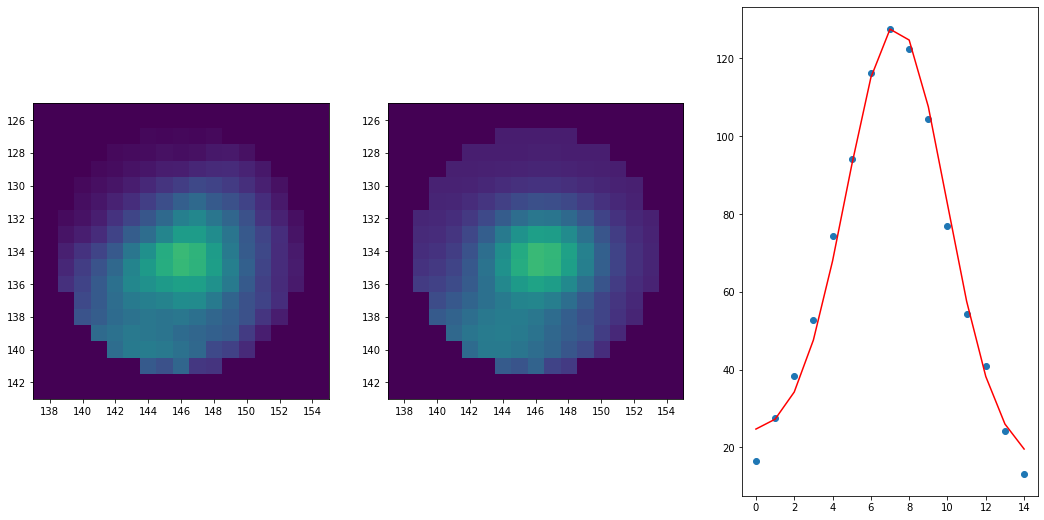

20.0 178.0 131.0
----------------------------
Image max = 188.35, spot max = 106.07
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 8
Chisquare = 1813.52, p = 0.0000
KS stat = 0.09, p = 0.0017
R_sq = 0.72, Adj. R-sq = 0.72
RMSE = 11.31
NRMSE = 0.24
F_NRMSE = 0.88
-------------------
Sigmas fit = (-2.01, -3.31, -2.94)
A fit = 69.18, B fit = 0.00
Total integral result, fit sum, observed sum = 18234.81, 41147.04, 38049.80
Foregroung integral value: 18234.81
----------------------------


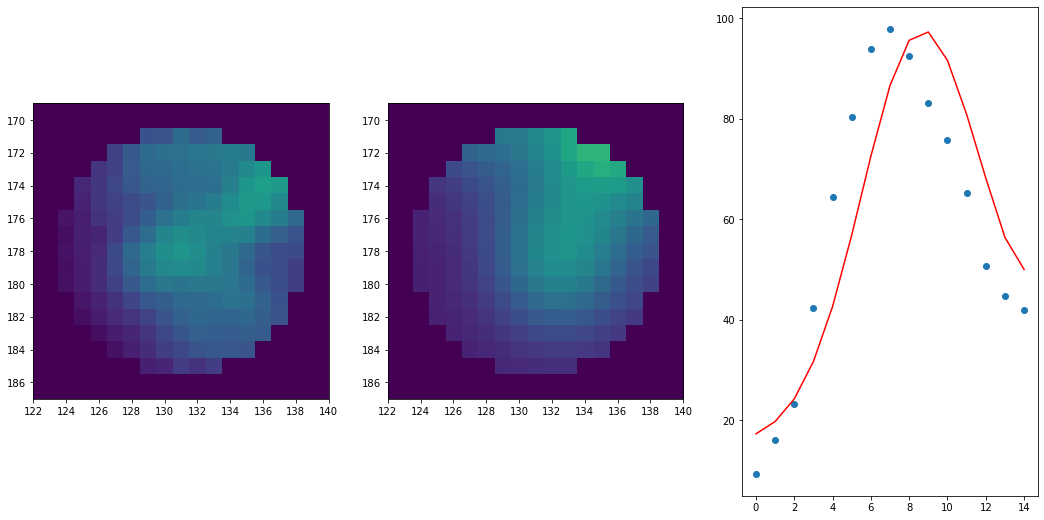

23.0 182.0 141.0
----------------------------
Image max = 188.35, spot max = 117.29
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 10
Chisquare = 1799.14, p = 0.0000
KS stat = 0.17, p = 0.0000
R_sq = 0.88, Adj. R-sq = 0.87
RMSE = 9.23
NRMSE = 0.22
F_NRMSE = 0.89
-------------------
Sigmas fit = (-1.43, 4.62, -2.41)
A fit = 104.31, B fit = 0.00
Total integral result, fit sum, observed sum = 22344.82, 35520.84, 34110.59
Foregroung integral value: 22344.82
----------------------------


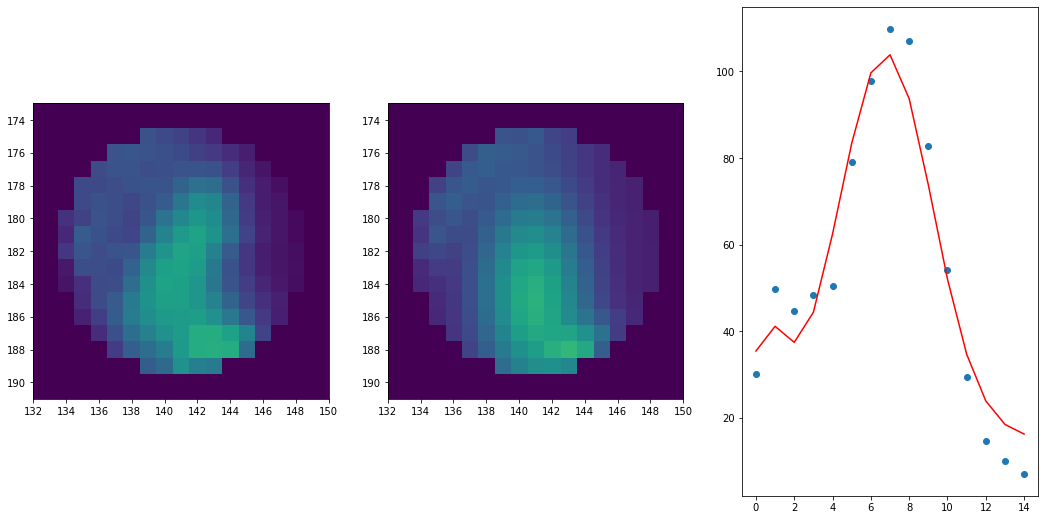

24.0 165.0 139.0
----------------------------
Image max = 188.35, spot max = 109.80
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 11
Chisquare = 2589.63, p = 0.0000
KS stat = 0.37, p = 0.0000
R_sq = -0.85, Adj. R-sq = -0.88
RMSE = 24.68
NRMSE = 0.46
F_NRMSE = 0.78
-------------------
Sigmas fit = (1.58, 3.15, 2.55)
A fit = 67.96, B fit = 0.00
Total integral result, fit sum, observed sum = 22344.82, 28794.20, 21082.97
Foregroung integral value: 22344.82
----------------------------


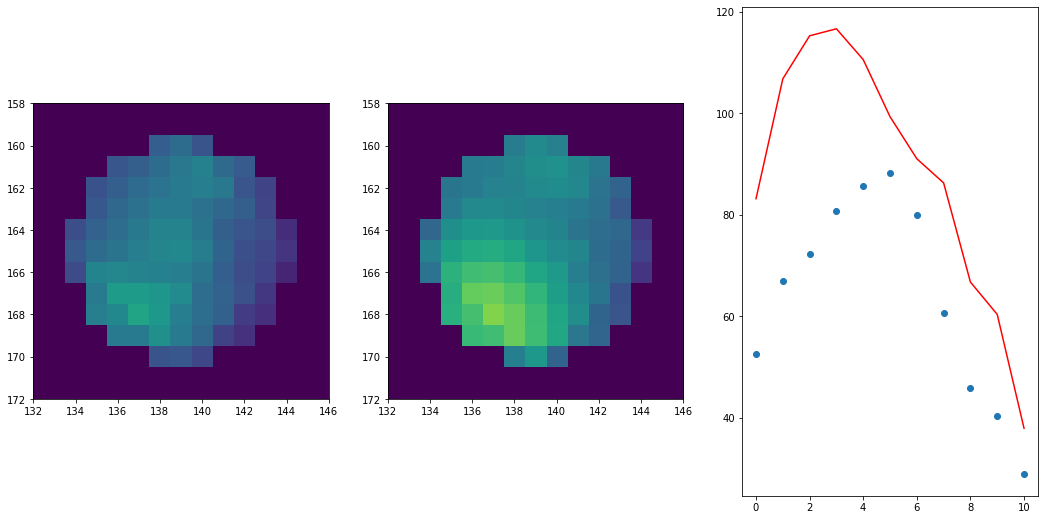

24.0 188.0 143.0
----------------------------
Image max = 188.35, spot max = 117.29
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 12
Chisquare = 1410.04, p = 0.0000
KS stat = 0.26, p = 0.0000
R_sq = 0.93, Adj. R-sq = 0.93
RMSE = 7.40
NRMSE = 0.20
F_NRMSE = 0.90
-------------------
Sigmas fit = (-0.92, 1.71, -1.82)
A fit = 80.40, B fit = 0.00
Total integral result, fit sum, observed sum = 3125.34, 32004.88, 30572.24
Foregroung integral value: 3125.34
----------------------------


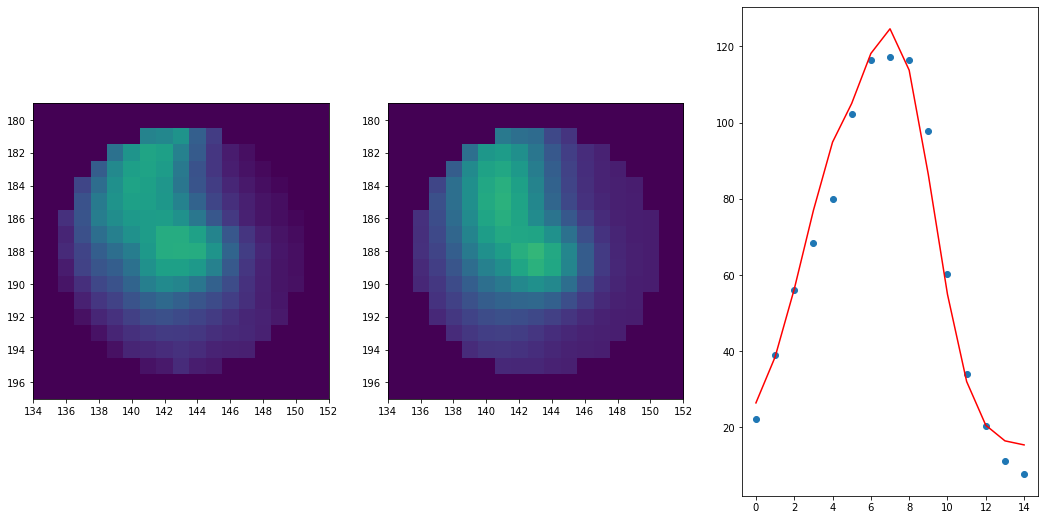

14.0 167.0 139.0
----------------------------
Image max = 188.35, spot max = 127.88
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 13
Chisquare = 2265.42, p = 0.0000
KS stat = 0.12, p = 0.0000
R_sq = 0.85, Adj. R-sq = 0.84
RMSE = 9.01
NRMSE = 0.22
F_NRMSE = 0.89
-------------------
Sigmas fit = (-1.26, 2.86, 2.77)
A fit = 79.66, B fit = 0.00
Total integral result, fit sum, observed sum = 10701.82, 46309.01, 44515.97
Foregroung integral value: 10701.82
----------------------------


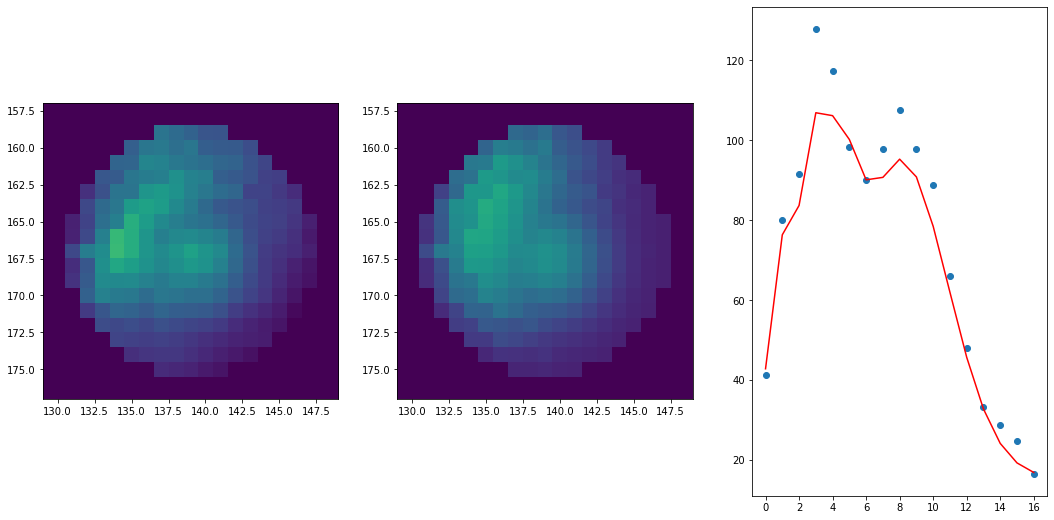

23.0 156.0 141.0
----------------------------
Image max = 188.35, spot max = 121.33
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 14
Chisquare = 8277.06, p = 0.0000
KS stat = 0.39, p = 0.0000
R_sq = -0.27, Adj. R-sq = -0.28
RMSE = 23.91
NRMSE = 0.52
F_NRMSE = 0.74
-------------------
Sigmas fit = (1.27, -4.22, 2.28)
A fit = 66.39, B fit = 0.00
Total integral result, fit sum, observed sum = 10701.82, 70789.58, 49766.26
Foregroung integral value: 10701.82
----------------------------


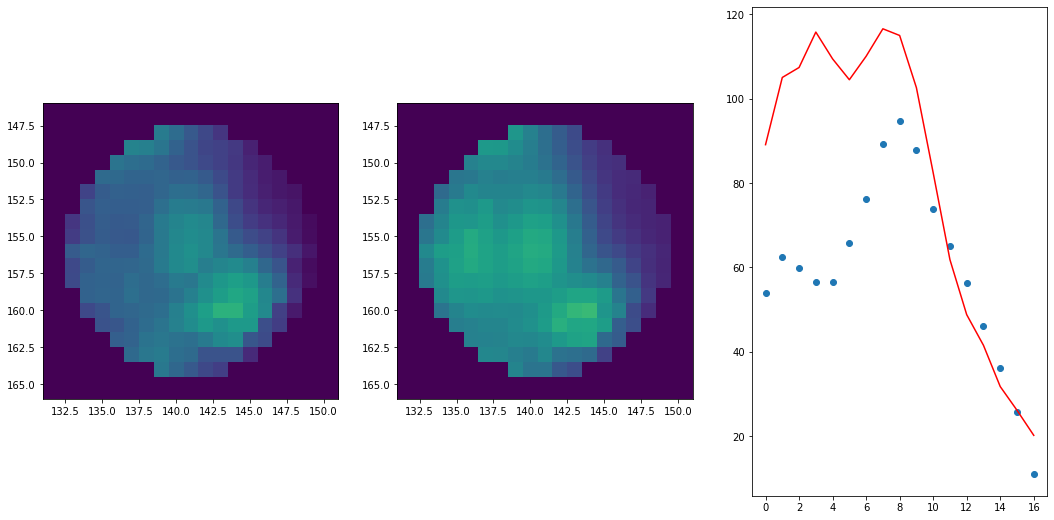

20.0 170.0 142.0
----------------------------
Image max = 188.35, spot max = 123.19
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 15
Chisquare = 4673.98, p = 0.0000
KS stat = 0.23, p = 0.0000
R_sq = 0.05, Adj. R-sq = 0.04
RMSE = 25.89
NRMSE = 0.52
F_NRMSE = 0.75
-------------------
Sigmas fit = (-0.93, 2.44, 2.14)
A fit = 71.67, B fit = 0.00
Total integral result, fit sum, observed sum = 10701.82, 41500.30, 28983.94
Foregroung integral value: 10701.82
----------------------------


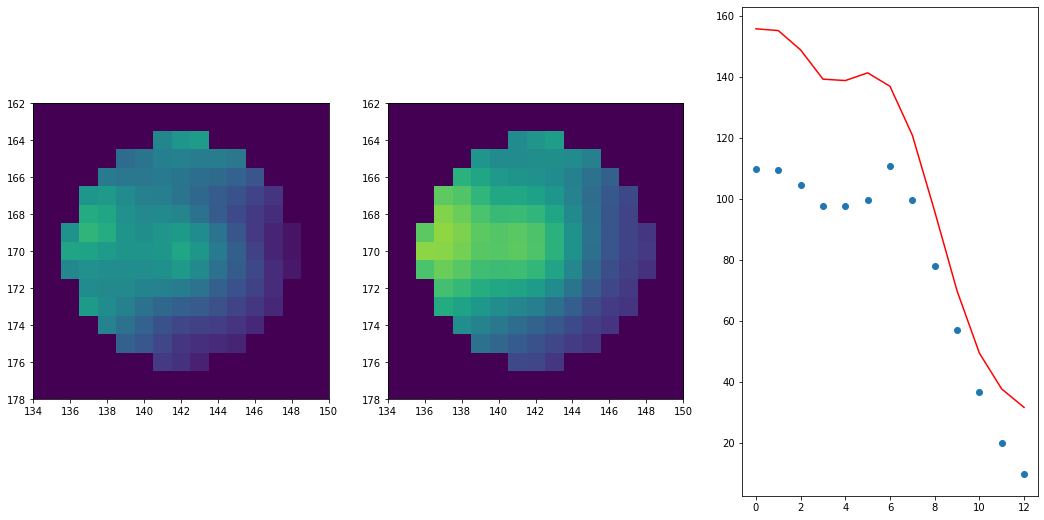

20.0 168.0 127.0
----------------------------
Image max = 188.35, spot max = 127.88
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 16
Chisquare = 9077.50, p = 0.0000
KS stat = 0.25, p = 0.0000
R_sq = 0.64, Adj. R-sq = 0.63
RMSE = 17.07
NRMSE = 0.41
F_NRMSE = 0.80
-------------------
Sigmas fit = (1.77, 3.91, -2.08)
A fit = 70.10, B fit = 0.00
Total integral result, fit sum, observed sum = 10701.82, 98815.99, 78101.58
Foregroung integral value: 10701.82
----------------------------


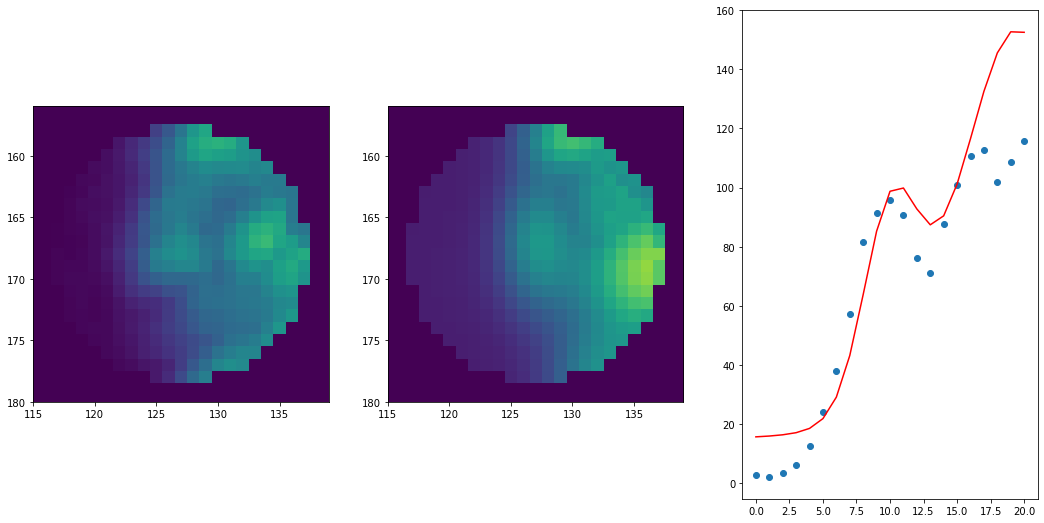

21.0 150.0 133.0
----------------------------
Image max = 188.35, spot max = 110.38
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 18
Chisquare = 3422.10, p = 0.0000
KS stat = 0.38, p = 0.0000
R_sq = -1.00, Adj. R-sq = -1.05
RMSE = 27.79
NRMSE = 0.55
F_NRMSE = 0.73
-------------------
Sigmas fit = (3.55, 10.60, 3.44)
A fit = 47.05, B fit = 0.00
Total integral result, fit sum, observed sum = 10701.82, 28150.99, 19610.59
Foregroung integral value: 10701.82
----------------------------


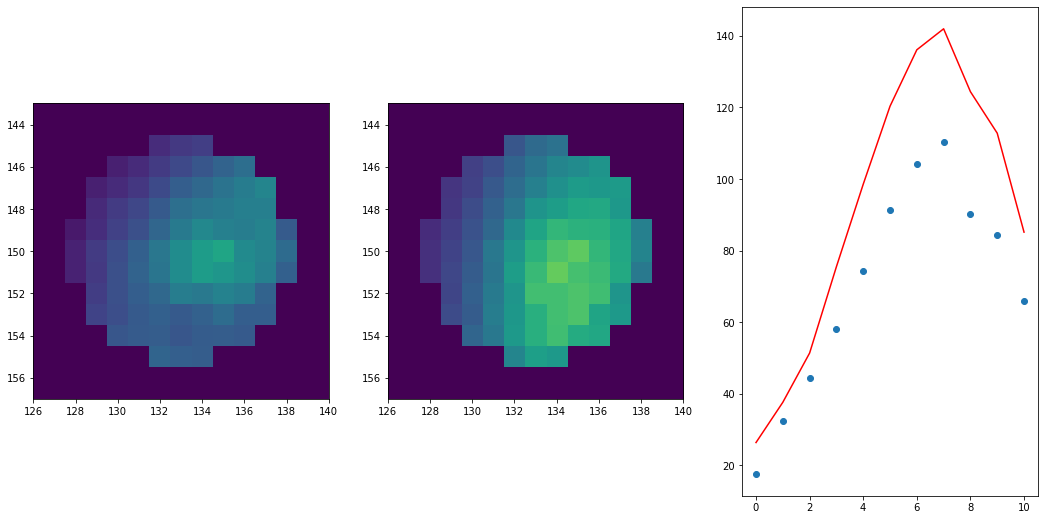

20.0 145.0 140.0
----------------------------
Image max = 188.35, spot max = 99.19
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 19
Chisquare = 3340.43, p = 0.0000
KS stat = 0.34, p = 0.0000
R_sq = -0.39, Adj. R-sq = -0.41
RMSE = 21.37
NRMSE = 0.45
F_NRMSE = 0.78
-------------------
Sigmas fit = (-2.91, 2.65, 2.90)
A fit = 53.06, B fit = 0.00
Total integral result, fit sum, observed sum = 10701.82, 36642.17, 27572.20
Foregroung integral value: 10701.82
----------------------------


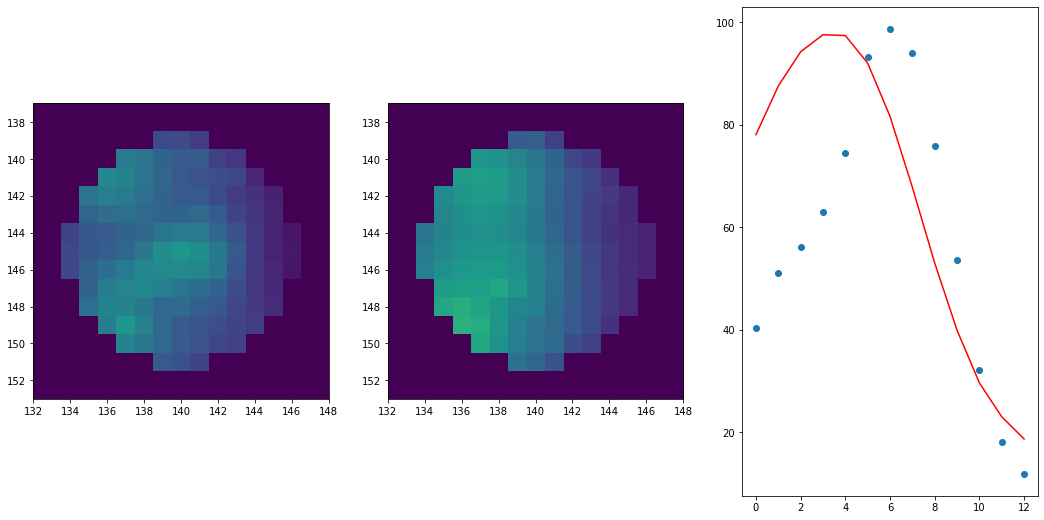

16.0 140.0 144.0
----------------------------
Image max = 188.35, spot max = 107.12
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 20
Chisquare = 391.11, p = 0.3628
KS stat = 0.09, p = 0.0727
R_sq = 0.87, Adj. R-sq = 0.87
RMSE = 7.27
NRMSE = 0.14
F_NRMSE = 0.93
-------------------
Sigmas fit = (-1.10, 2.56, 3.32)
A fit = 56.22, B fit = 0.00
Total integral result, fit sum, observed sum = 7102.30, 20432.34, 19877.62
Foregroung integral value: 7102.30
----------------------------


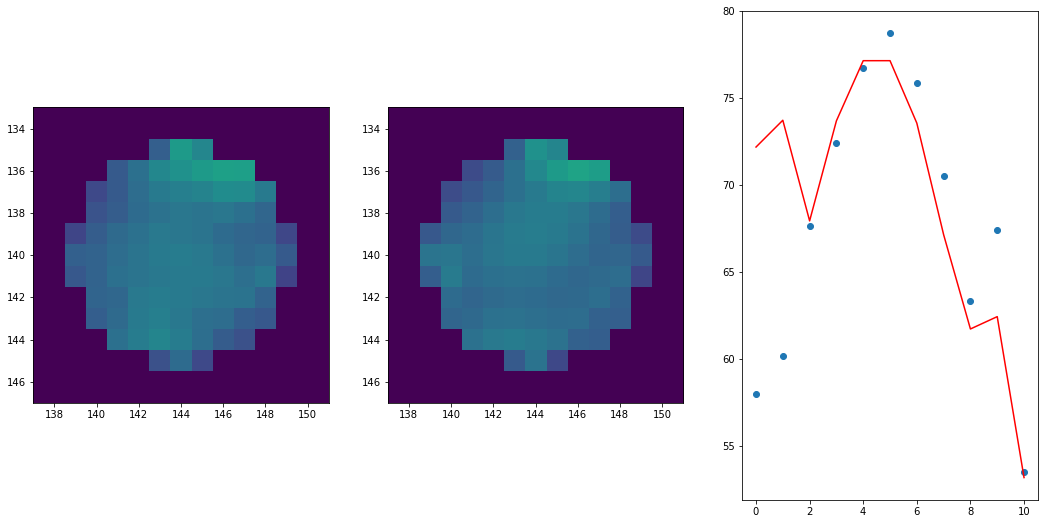

23.0 148.0 137.0
----------------------------
Image max = 188.35, spot max = 89.50
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 21
Chisquare = 4418.24, p = 0.0000
KS stat = 0.31, p = 0.0000
R_sq = -0.23, Adj. R-sq = -0.25
RMSE = 21.92
NRMSE = 0.50
F_NRMSE = 0.76
-------------------
Sigmas fit = (0.02, -1.98, 1.93)
A fit = 65.00, B fit = 0.00
Total integral result, fit sum, observed sum = 7102.30, 36573.90, 25805.81
Foregroung integral value: 7102.30
----------------------------


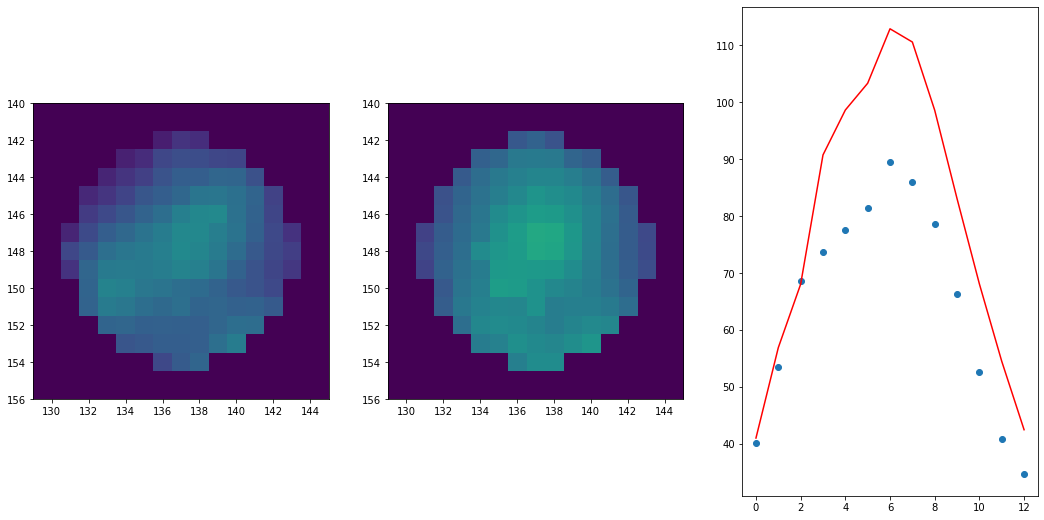

14.0 145.0 143.0
----------------------------
Image max = 188.35, spot max = 91.44
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 22
Chisquare = 800.80, p = 0.0000
KS stat = 0.10, p = 0.0062
R_sq = 0.82, Adj. R-sq = 0.82
RMSE = 7.56
NRMSE = 0.18
F_NRMSE = 0.91
-------------------
Sigmas fit = (1.29, 3.17, 2.44)
A fit = 64.91, B fit = 0.00
Total integral result, fit sum, observed sum = 8759.68, 26162.09, 24434.07
Foregroung integral value: 8759.68
----------------------------


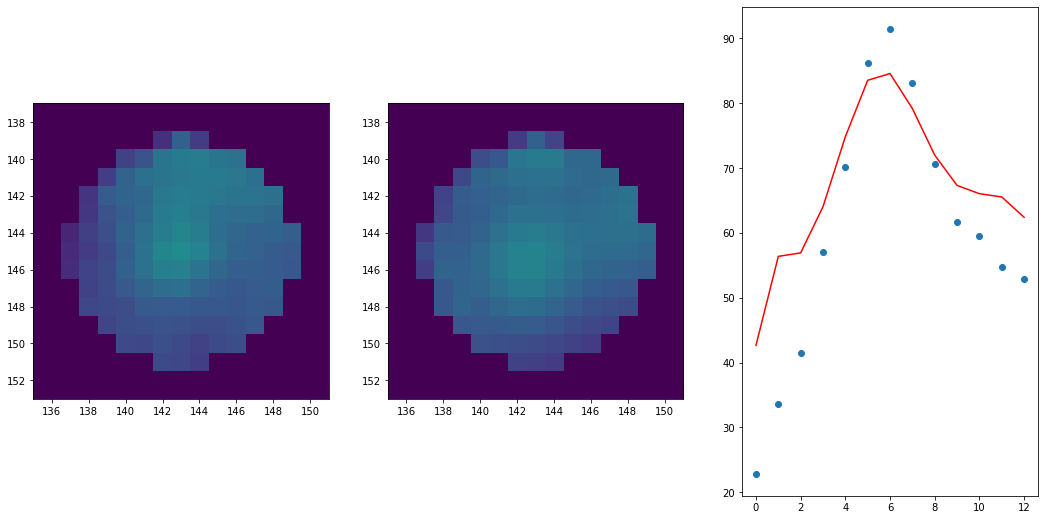

14.0 141.0 148.0
----------------------------
Image max = 188.35, spot max = 90.82
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 23
Chisquare = 354.19, p = 0.8431
KS stat = 0.08, p = 0.1458
R_sq = 0.88, Adj. R-sq = 0.88
RMSE = 6.07
NRMSE = 0.14
F_NRMSE = 0.93
-------------------
Sigmas fit = (-1.30, 4.38, 2.68)
A fit = 53.25, B fit = 0.00
Total integral result, fit sum, observed sum = 10971.87, 17128.94, 16898.03
Foregroung integral value: 10971.87
----------------------------


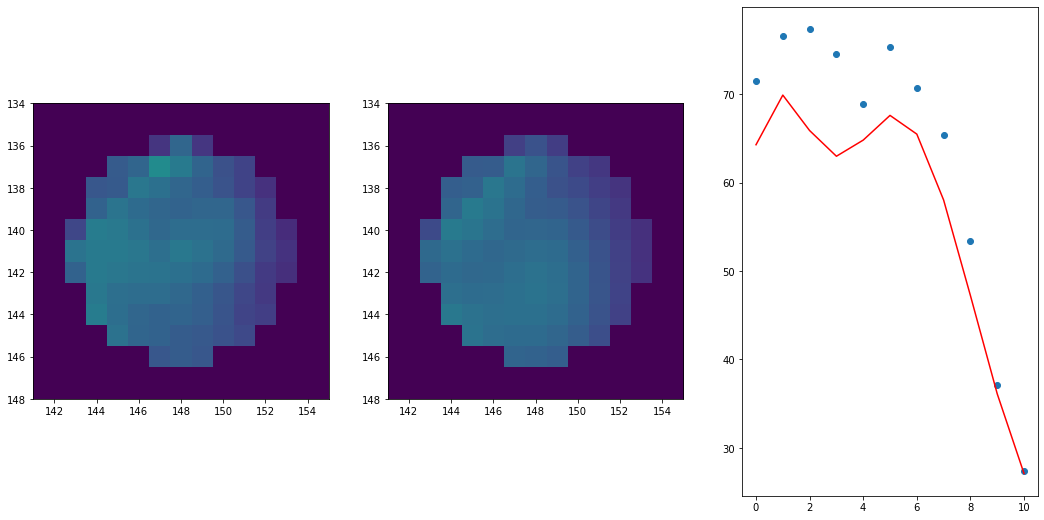

26.0 161.0 140.0
----------------------------
Image max = 188.35, spot max = 88.12
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 24
Chisquare = 2419.62, p = 0.0000
KS stat = 0.30, p = 0.0000
R_sq = -0.07, Adj. R-sq = -0.09
RMSE = 19.39
NRMSE = 0.46
F_NRMSE = 0.77
-------------------
Sigmas fit = (-1.13, 2.71, 3.07)
A fit = 64.02, B fit = 0.00
Total integral result, fit sum, observed sum = 10971.87, 22344.90, 16429.42
Foregroung integral value: 10971.87
----------------------------


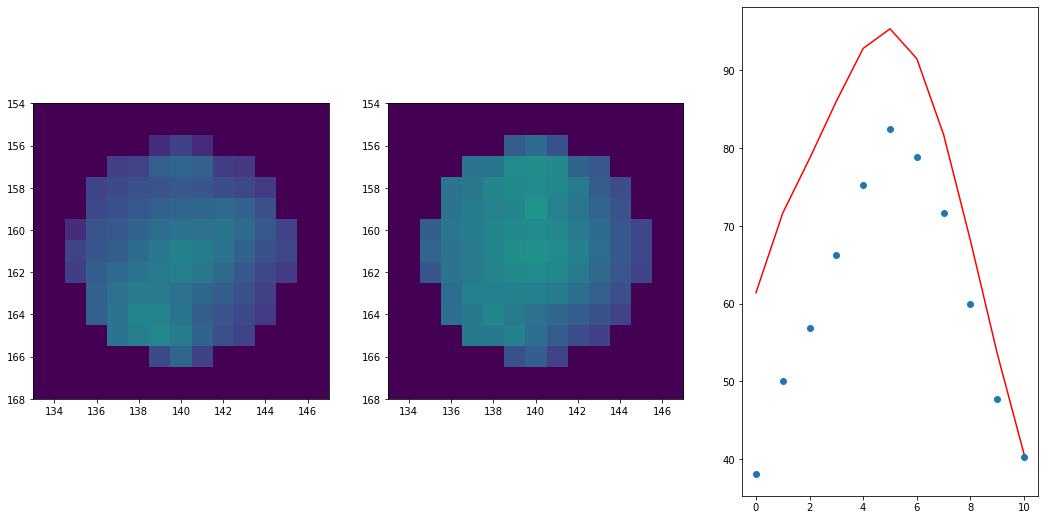

19.0 141.0 136.0
----------------------------
Image max = 188.35, spot max = 98.69
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 25
Chisquare = 6910.27, p = 0.0000
KS stat = 0.42, p = 0.0000
R_sq = -0.72, Adj. R-sq = -0.74
RMSE = 26.27
NRMSE = 0.73
F_NRMSE = 0.65
-------------------
Sigmas fit = (-1.41, -2.01, -2.91)
A fit = 62.92, B fit = 0.00
Total integral result, fit sum, observed sum = 10971.87, 34978.15, 20956.62
Foregroung integral value: 10971.87
----------------------------


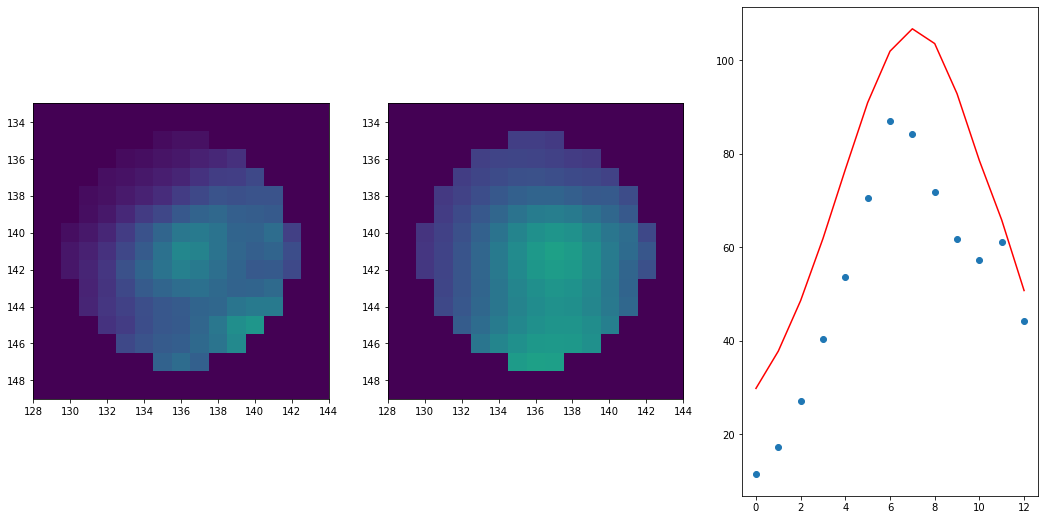

18.0 192.0 137.0
----------------------------
Image max = 188.35, spot max = 76.96
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 27
Chisquare = 681.78, p = 0.0000
KS stat = 0.15, p = 0.0002
R_sq = 0.76, Adj. R-sq = 0.75
RMSE = 7.21
NRMSE = 0.22
F_NRMSE = 0.89
-------------------
Sigmas fit = (1.70, 2.55, 2.09)
A fit = 61.48, B fit = 15.16
Total integral result, fit sum, observed sum = 15822.00, 13005.35, 12837.88
Foregroung integral value: 7533.99
----------------------------


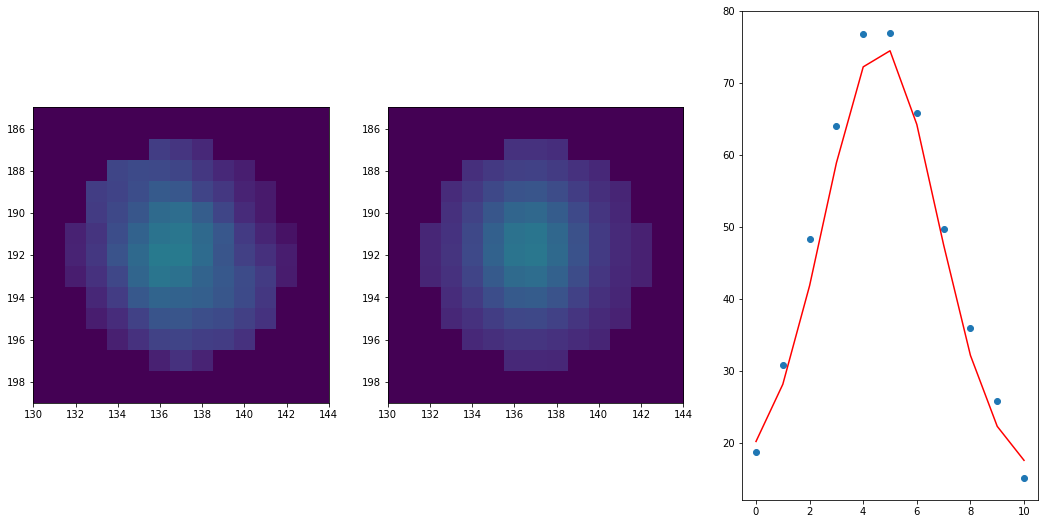

25.0 143.0 148.0
----------------------------
Image max = 188.35, spot max = 65.42
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 32
Chisquare = 625.86, p = 0.0000
KS stat = 0.14, p = 0.0015
R_sq = 0.73, Adj. R-sq = 0.72
RMSE = 7.19
NRMSE = 0.23
F_NRMSE = 0.88
-------------------
Sigmas fit = (1.06, 4.08, 3.32)
A fit = 47.04, B fit = 0.00
Total integral result, fit sum, observed sum = 9075.62, 12512.33, 12106.54
Foregroung integral value: 9075.62
----------------------------


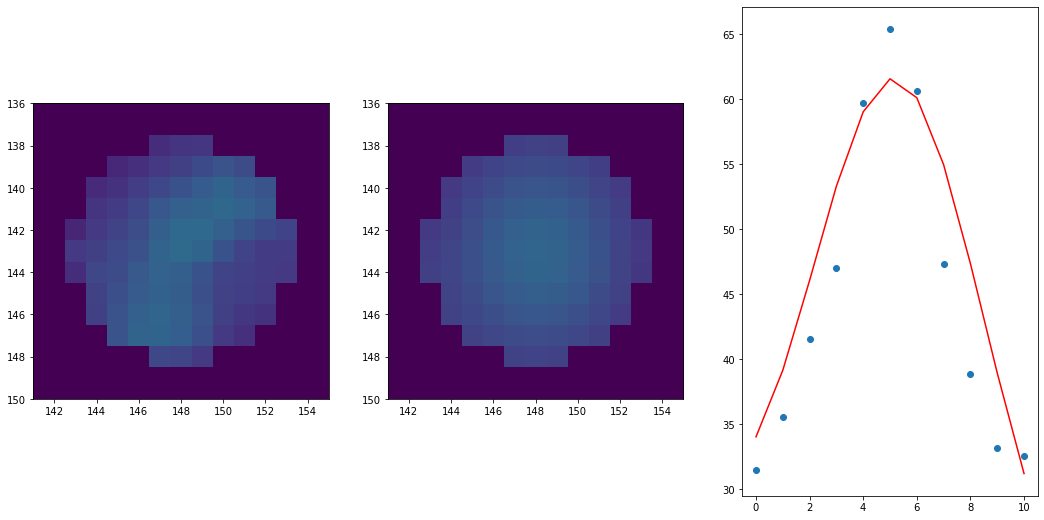

27.0 165.0 151.0
----------------------------
Image max = 188.35, spot max = 71.35
Neighbours idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 32, 41]
Spot idx = 41
Chisquare = 191.83, p = 0.9520
KS stat = 0.24, p = 0.0000
R_sq = 0.90, Adj. R-sq = 0.89
RMSE = 4.53
NRMSE = 0.17
F_NRMSE = 0.92
-------------------
Sigmas fit = (1.00, 1.61, 2.12)
A fit = 62.37, B fit = 0.00
Total integral result, fit sum, observed sum = 2886.48, 6620.52, 6328.64
Foregroung integral value: 2886.48
----------------------------


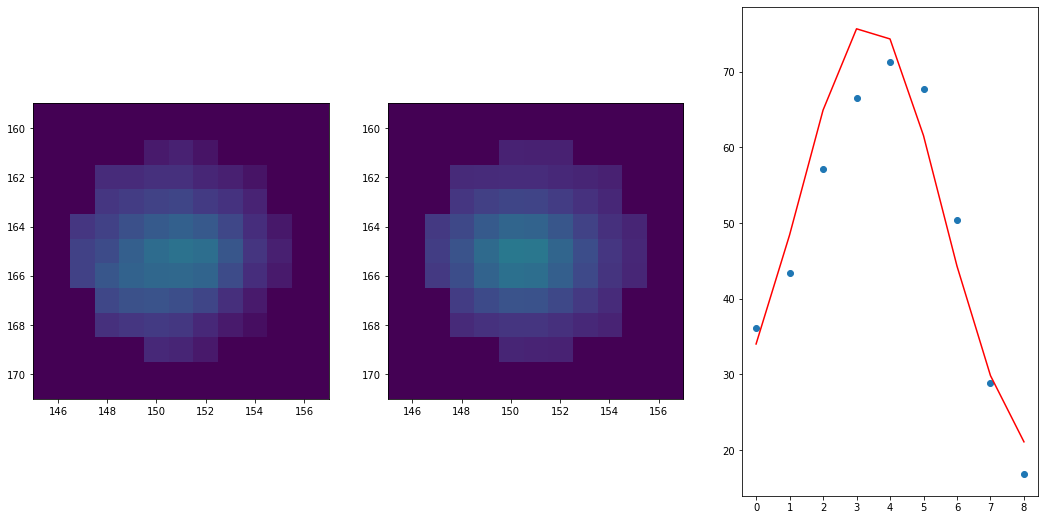

14.0 203.0 191.0
----------------------------
Image max = 188.35, spot max = 49.63
Neighbours idx = [45]
Spot idx = 45
Chisquare = 107.98, p = 1.0000
KS stat = 0.07, p = 0.5711
R_sq = 0.85, Adj. R-sq = 0.85
RMSE = 3.27
NRMSE = 0.13
F_NRMSE = 0.93
-------------------
Sigmas fit = (1.34, 2.45, 2.71)
A fit = 38.34, B fit = 10.22
Total integral result, fit sum, observed sum = 10127.24, 5893.97, 5893.97
Foregroung integral value: 4625.23
----------------------------


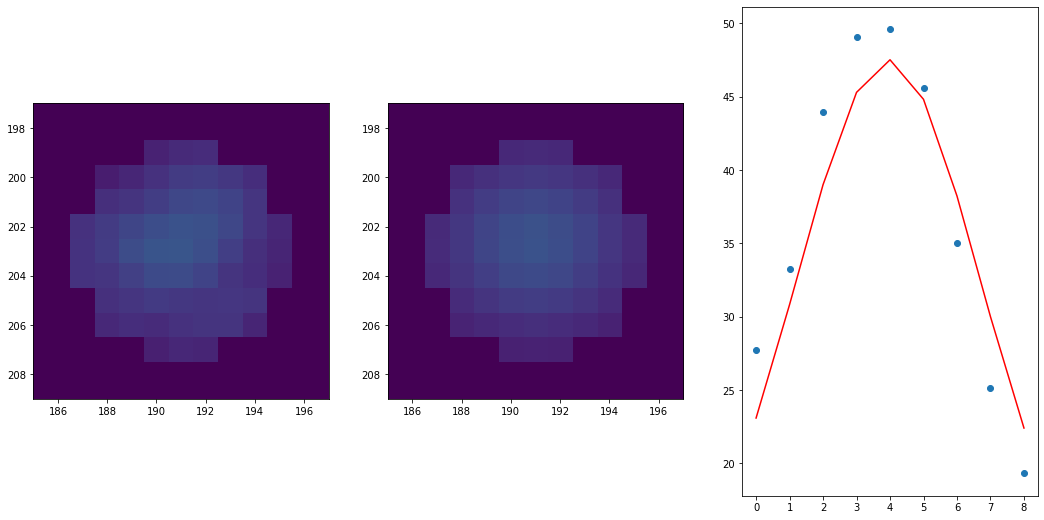

21.0 208.0 168.0
----------------------------
Image max = 188.35, spot max = 79.77
Neighbours idx = [34]
Spot idx = 34
Chisquare = 111.74, p = 1.0000
KS stat = 0.06, p = 0.8658
R_sq = 0.94, Adj. R-sq = 0.94
RMSE = 3.98
NRMSE = 0.12
F_NRMSE = 0.94
-------------------
Sigmas fit = (1.51, 2.45, 3.53)
A fit = 74.65, B fit = 0.00
Total integral result, fit sum, observed sum = 13151.55, 7924.20, 7922.77
Foregroung integral value: 13151.55
----------------------------


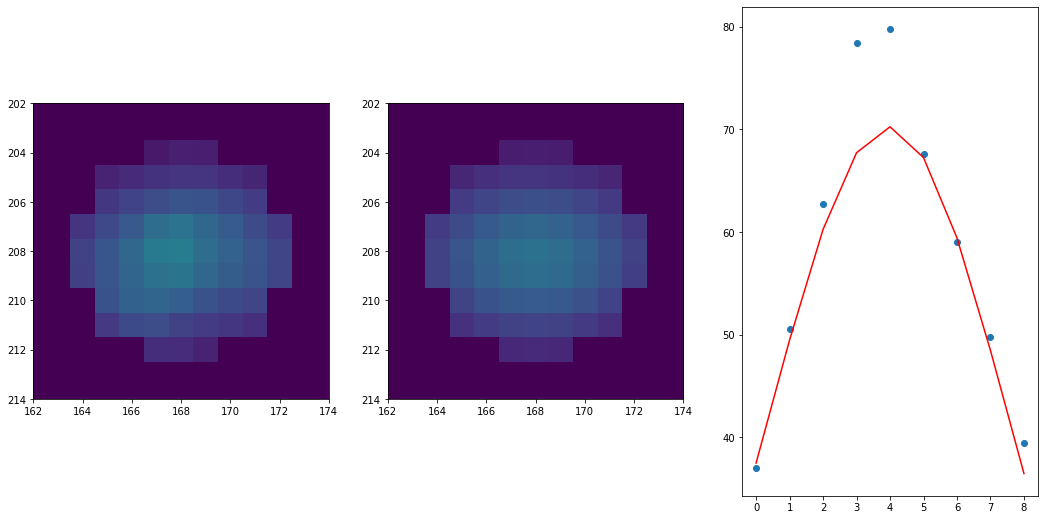

23.0 162.0 217.0
----------------------------
Image max = 188.35, spot max = 117.83
Neighbours idx = [17, 40]
Spot idx = 17
Chisquare = 543.27, p = 0.8170
KS stat = 0.10, p = 0.0062
R_sq = 0.95, Adj. R-sq = 0.95
RMSE = 5.26
NRMSE = 0.14
F_NRMSE = 0.93
-------------------
Sigmas fit = (1.35, 3.35, 2.61)
A fit = 114.90, B fit = 6.97
Total integral result, fit sum, observed sum = 23316.26, 22485.19, 21313.06
Foregroung integral value: 18350.70
----------------------------


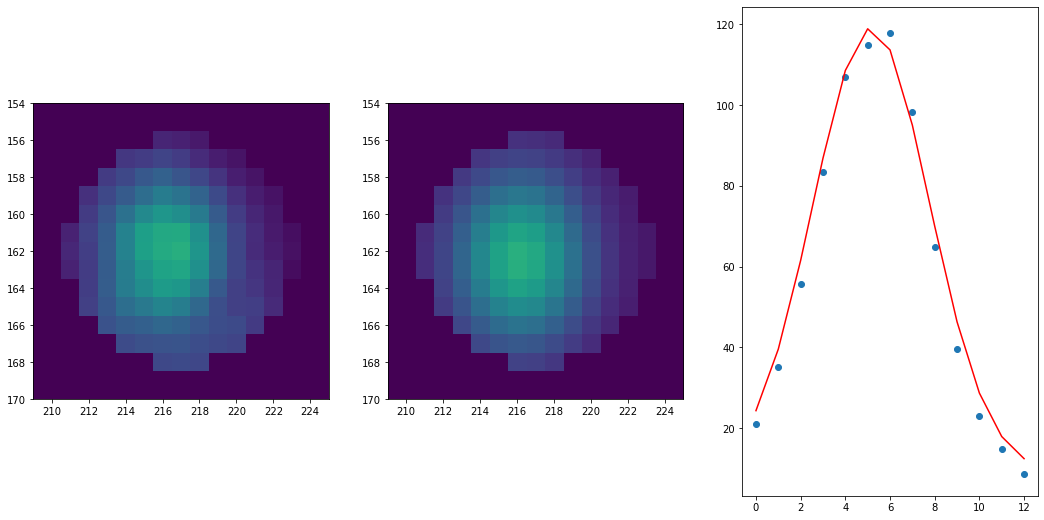

25.0 169.0 209.0
----------------------------
Image max = 188.35, spot max = 62.91
Neighbours idx = [17, 40]
Spot idx = 40
Chisquare = 109.67, p = 1.0000
KS stat = 0.06, p = 0.8658
R_sq = 0.93, Adj. R-sq = 0.93
RMSE = 3.26
NRMSE = 0.12
F_NRMSE = 0.94
-------------------
Sigmas fit = (1.15, 2.02, 2.79)
A fit = 55.60, B fit = 1.92
Total integral result, fit sum, observed sum = 5638.70, 6353.10, 6353.10
Foregroung integral value: 4884.63
----------------------------


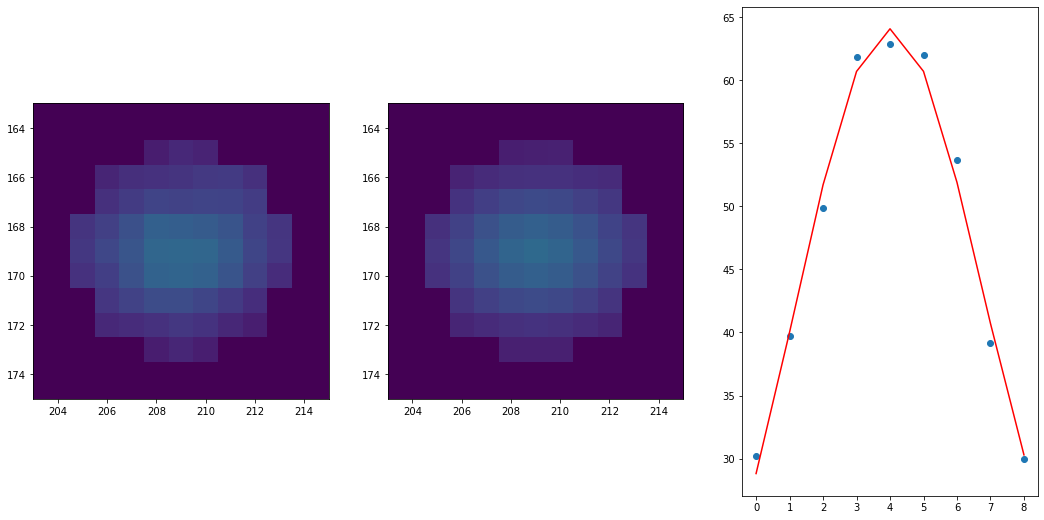

23.0 207.0 189.0
----------------------------
Image max = 188.35, spot max = 82.26
Neighbours idx = [30]
Spot idx = 30
Chisquare = 158.16, p = 0.9998
KS stat = 0.06, p = 0.8658
R_sq = 0.94, Adj. R-sq = 0.94
RMSE = 4.79
NRMSE = 0.14
F_NRMSE = 0.93
-------------------
Sigmas fit = (1.17, 2.30, 4.74)
A fit = 79.12, B fit = 3.86
Total integral result, fit sum, observed sum = 16590.94, 8317.38, 8317.38
Foregroung integral value: 13627.60
----------------------------


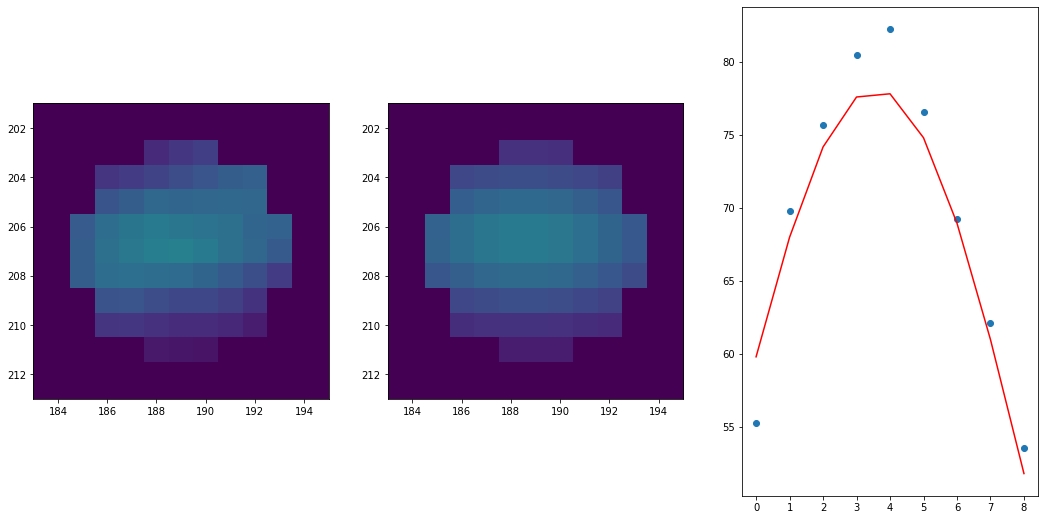

25.0 138.0 162.0
----------------------------
Image max = 188.35, spot max = 69.32
Neighbours idx = [43]
Spot idx = 43
Chisquare = 161.61, p = 0.9996
KS stat = 0.07, p = 0.5711
R_sq = 0.91, Adj. R-sq = 0.90
RMSE = 3.94
NRMSE = 0.15
F_NRMSE = 0.93
-------------------
Sigmas fit = (1.08, 2.31, 2.67)
A fit = 56.77, B fit = 8.25
Total integral result, fit sum, observed sum = 8458.79, 6178.86, 6178.86
Foregroung integral value: 5131.35
----------------------------


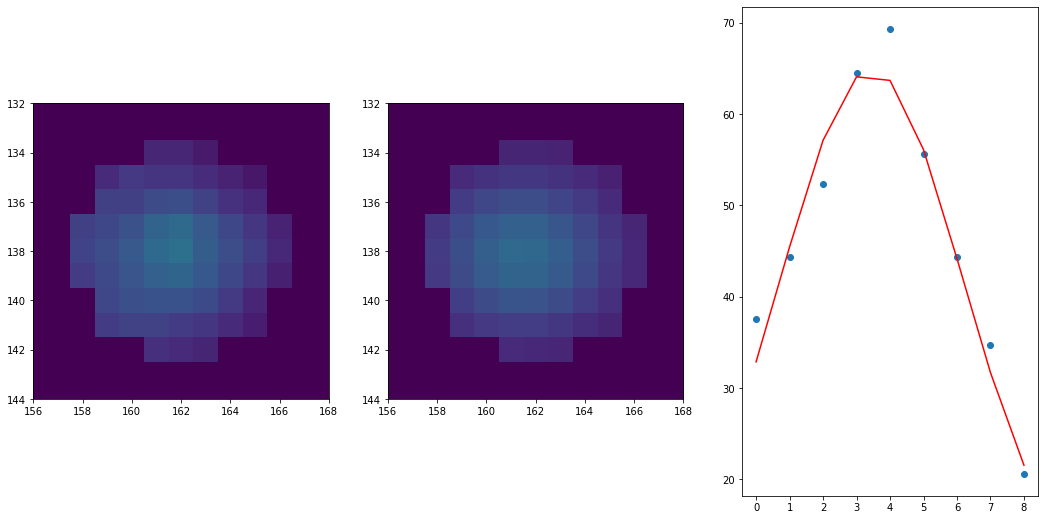

25.0 142.0 190.0
----------------------------
Image max = 188.35, spot max = 85.97
Neighbours idx = [33]
Spot idx = 33
Chisquare = 50.47, p = 1.0000
KS stat = 0.04, p = 0.9839
R_sq = 0.98, Adj. R-sq = 0.98
RMSE = 2.57
NRMSE = 0.07
F_NRMSE = 0.96
-------------------
Sigmas fit = (1.11, 2.33, 3.09)
A fit = 82.83, B fit = 6.51
Total integral result, fit sum, observed sum = 12056.76, 8217.57, 8217.57
Foregroung integral value: 8928.52
----------------------------


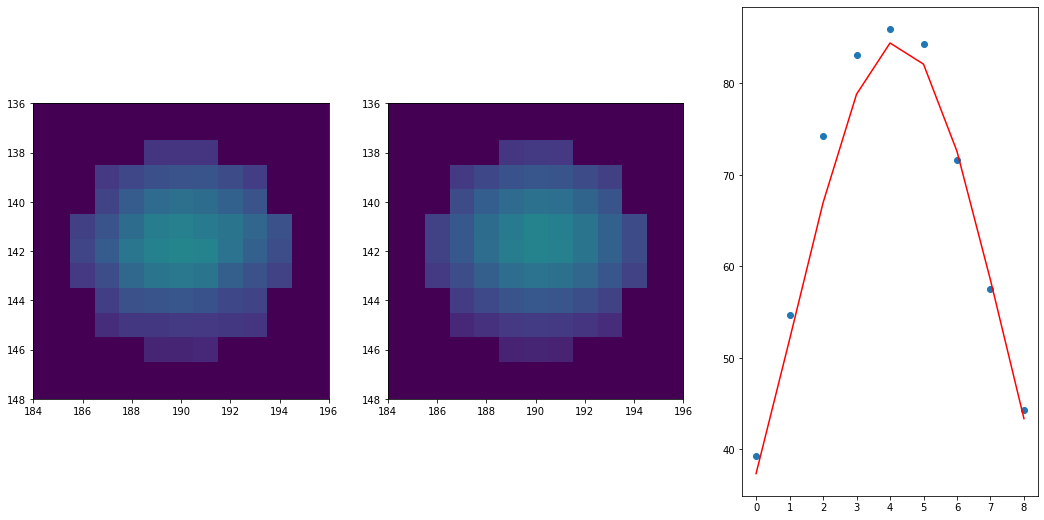

25.0 197.0 155.0
----------------------------
Image max = 188.35, spot max = 66.18
Neighbours idx = [47]
Spot idx = 47
Chisquare = 63.30, p = 1.0000
KS stat = 0.05, p = 0.9201
R_sq = 0.97, Adj. R-sq = 0.97
RMSE = 2.35
NRMSE = 0.10
F_NRMSE = 0.95
-------------------
Sigmas fit = (1.10, 2.11, 2.53)
A fit = 60.74, B fit = 5.28
Total integral result, fit sum, observed sum = 6726.96, 5399.15, 5399.15
Foregroung integral value: 4845.98
----------------------------


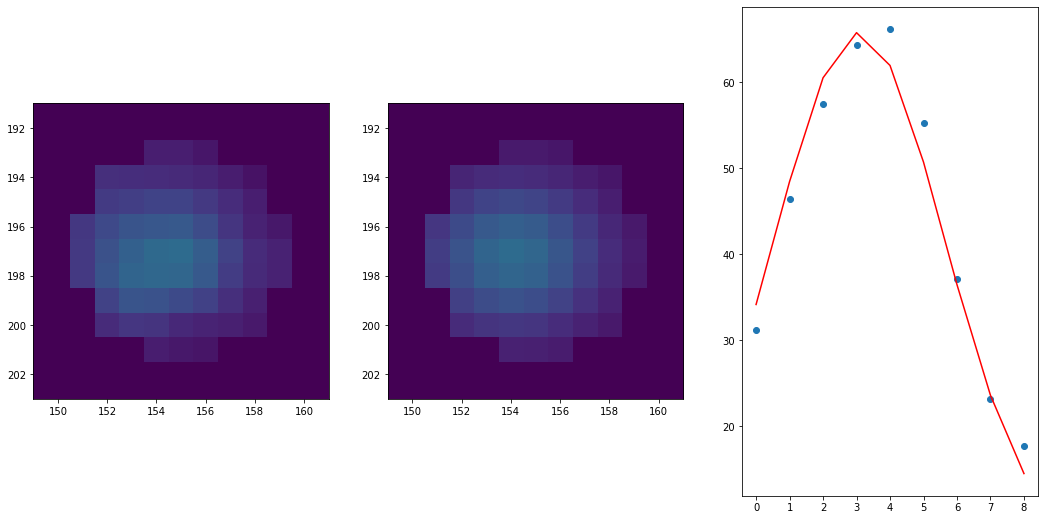

27.0 150.0 171.0
----------------------------
Image max = 188.35, spot max = 77.69
Neighbours idx = [38]
Spot idx = 38
Chisquare = 134.20, p = 1.0000
KS stat = 0.04, p = 0.9839
R_sq = 0.94, Adj. R-sq = 0.94
RMSE = 4.07
NRMSE = 0.14
F_NRMSE = 0.93
-------------------
Sigmas fit = (1.12, 2.13, 3.26)
A fit = 72.41, B fit = 6.36
Total integral result, fit sum, observed sum = 10592.32, 7034.41, 7034.41
Foregroung integral value: 7611.60
----------------------------


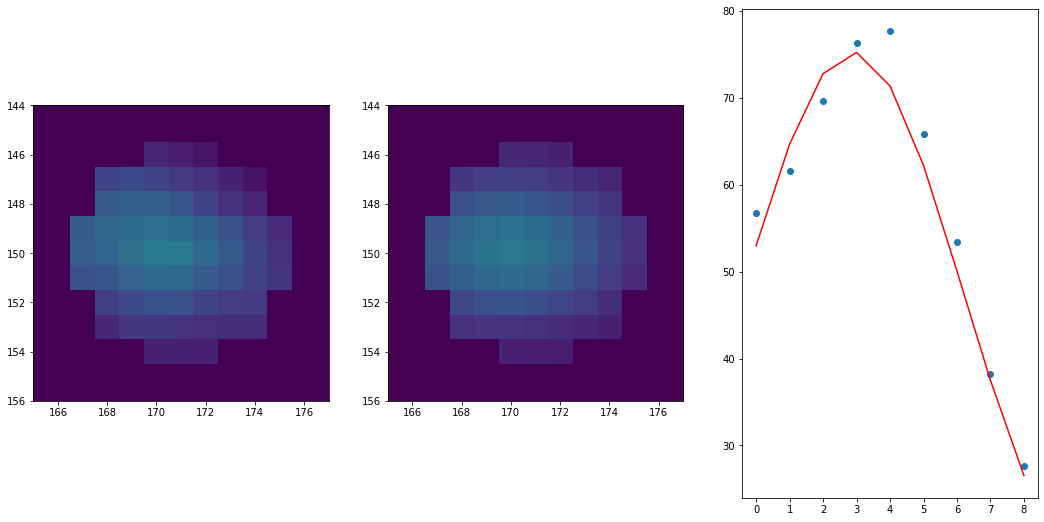

27.0 154.0 180.0
----------------------------
Image max = 188.35, spot max = 52.74
Neighbours idx = [48]
Spot idx = 48
Chisquare = 100.43, p = 1.0000
KS stat = 0.07, p = 0.5711
R_sq = 0.93, Adj. R-sq = 0.93
RMSE = 2.82
NRMSE = 0.14
F_NRMSE = 0.93
-------------------
Sigmas fit = (1.12, 1.98, 2.94)
A fit = 48.08, B fit = 5.61
Total integral result, fit sum, observed sum = 6435.59, 4791.74, 4791.74
Foregroung integral value: 4232.39
----------------------------


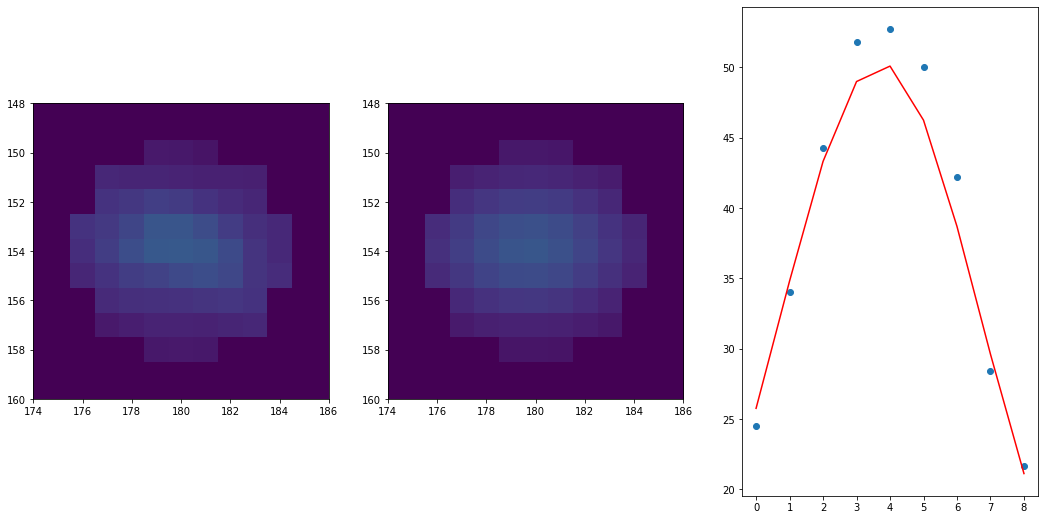

27.0 156.0 192.0
----------------------------
Image max = 188.35, spot max = 79.36
Neighbours idx = [36]
Spot idx = 36
Chisquare = 123.57, p = 1.0000
KS stat = 0.04, p = 0.9955
R_sq = 0.95, Adj. R-sq = 0.94
RMSE = 4.08
NRMSE = 0.13
F_NRMSE = 0.93
-------------------
Sigmas fit = (1.22, 2.20, 2.79)
A fit = 77.00, B fit = 5.34
Total integral result, fit sum, observed sum = 10147.71, 7279.08, 7279.08
Foregroung integral value: 7750.89
----------------------------


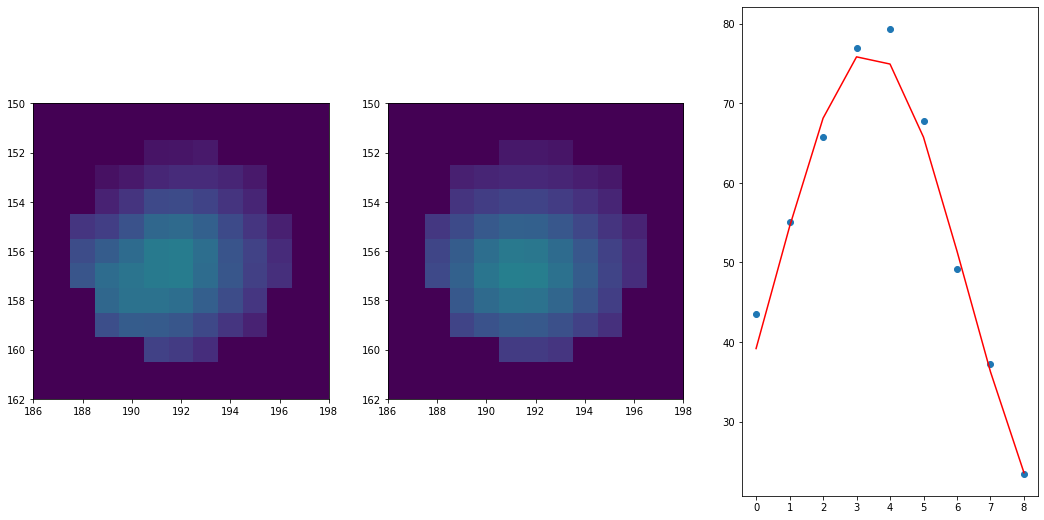

28.0 173.0 177.0
----------------------------
Image max = 188.35, spot max = 94.22
Neighbours idx = [29]
Spot idx = 29
Chisquare = 155.59, p = 0.9999
KS stat = 0.05, p = 0.9597
R_sq = 0.95, Adj. R-sq = 0.95
RMSE = 4.37
NRMSE = 0.12
F_NRMSE = 0.94
-------------------
Sigmas fit = (1.14, 2.54, 2.24)
A fit = 89.05, B fit = 7.71
Total integral result, fit sum, observed sum = 10772.36, 8471.96, 8471.96
Foregroung integral value: 7771.18
----------------------------


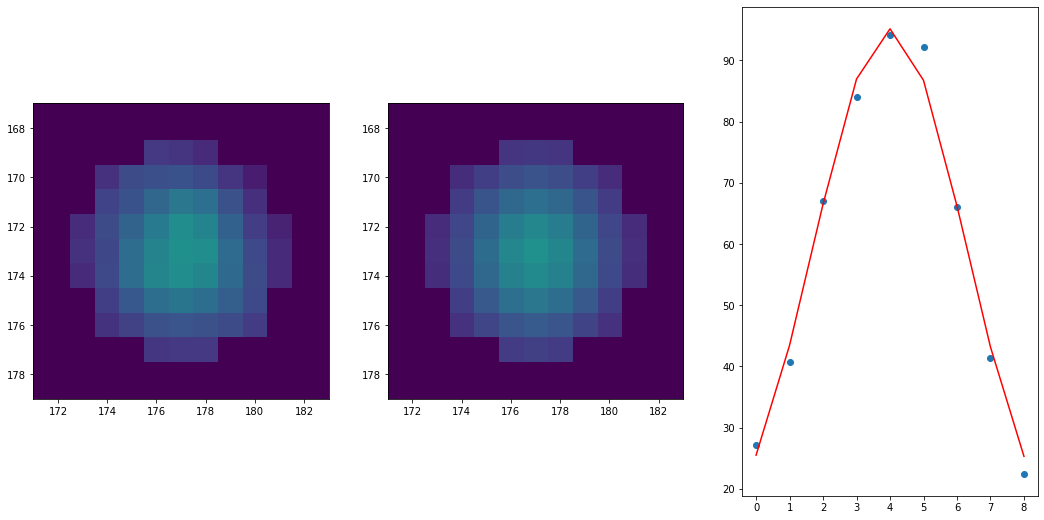

[0, 1, 3, 5, 6, 11, 14, 15, 16, 18, 19, 21, 24, 25]


In [69]:
import ipdb

img_max = img.max()

fit_again_idx = []

# Calculate goodness_of_fit metrics for each spot
# and determine which peaks should be fitted again
for obj_id, df_obj in df_spotQUANT.groupby(level=0):
    neigh_idx = df_obj['neigh_idx'].iloc[0]
    obj_3D_lab = spots_4D_lab[neigh_idx].max(axis=0)
    obj_3D_mask = obj_3D_lab>0
    obj_coeffs = [c for i in neigh_idx for c in fitted_coeffs[i]]
    z_obj, y_obj, x_obj = np.nonzero(obj_3D_mask)
    obj_num_spots = len(neigh_idx)
    obj_fit_data = model._gauss3D(z_obj, y_obj, x_obj,
                                  np.array(obj_coeffs),
                                  obj_num_spots, num_coeffs, 0)
    img_obj_fit = np.zeros_like(img)
    img_obj_fit[z_obj, y_obj, x_obj] = obj_fit_data
    obj_s_idxs = df_obj['neigh_idx'].iloc[0]
    # Iterate single spots
    for s in obj_s_idxs:
        z_s, y_s, x_s = np.nonzero(spots_4D_lab[s])
        
        # Initial guess
        (z0_guess, y0_guess, x0_guess,
        sz_guess, sy_guess, sx_guess,
        A_guess, B_guess) = init_guess_li[s]
        
        # Fitted coeffs 
        (z0_fit, y0_fit, x0_fit,
        sz_fit, sy_fit, sx_fit,
        A_fit, B_fit) = fitted_coeffs[s]
        
        print(z0_guess, y0_guess, x0_guess)

        # Goodness of fit
        ddof = num_coeffs
        s_data = img[z_s, y_s, x_s]
        s_fit_data = img_obj_fit[z_s, y_s, x_s]
        (chisq, p_chisq, R_sq, RMSE, 
         ks, p_ks, adj_Rsq, 
         NRMSE, F_NRMSE) = model.goodness_of_fit(s_data, s_fit_data, ddof)
        
        # Store s idx of badly fitted peaks
        if F_NRMSE <= 0.8:
            fit_again_idx.append(s)
        # Store properties of good peaks
        else:
            zyx_centers = np.abs(np.array([z0_fit, y0_fit, x0_fit]))
            zyx_sigmas = np.abs(np.array([sz_fit, sy_fit, sx_fit]))
            
            I_tot, I_foregr = model_temp().integrate(
                            zyx_centers, zyx_sigmas, A_fit, B_fit, 
                            lower_bounds=None, upper_bounds=None
            )
            
            df_spotQUANT = model_temp().store_metrics_good_spots(
                                     df_spotQUANT, obj_id, s,
                                     fitted_coeffs[s], I_tot, I_foregr
            )

        # Testing
        print('----------------------------')
        print(f'Image max = {img_max:.2f}, spot max = {s_data.max():.2f}')
        print(f'Neighbours idx = {obj_s_idxs}')
        print('Spot idx =', s)
        print(f'Chisquare = {chisq:.2f}, p = {p_chisq:.4f}')
        print(f'KS stat = {ks:.2f}, p = {p_ks:.4f}')
        print(f'R_sq = {R_sq:.2f}, Adj. R-sq = {adj_Rsq:.2f}')
        print(f'RMSE = {RMSE:.2f}')
        print(f'NRMSE = {NRMSE:.2f}')
        print(f'F_NRMSE = {F_NRMSE:.2f}')
        print('-------------------')
        print(f'Sigmas fit = ({sz_fit:.2f}, {sy_fit:.2f}, {sx_fit:.2f})')
        print(f'A fit = {A_fit:.2f}, B fit = {B_fit:.2f}')
        print(f'Total integral result, fit sum, observed sum = {I_tot:.2f}, {s_fit_data.sum():.2f}, {s_data.sum():.2f}')
        print(f'Foregroung integral value: {I_foregr:.2f}')
        print('----------------------------')
        
              
        fig, ax = plt.subplots(1,3, figsize=[18,9])

        img_s = np.zeros_like(img)
        img_s[z_s, y_s, x_s] = s_data

        img_s_fit = np.zeros_like(img)
        img_s_fit[z_s, y_s, x_s] = s_fit_data

        y_intens = img_s.max(axis=0)[int(y0_guess)]
        y_intens = y_intens[y_intens!=0]
        
        y_gauss = img_s_fit.max(axis=0)[int(y0_guess)]
        y_gauss = y_gauss[y_gauss!=0]

        ax[0].imshow(img_s.max(axis=0), vmax=img_max)
        ax[1].imshow(img_s_fit.max(axis=0), vmax=img_max)
        ax[2].scatter(range(len(y_intens)), y_intens)
        ax[2].plot(range(len(y_gauss)), y_gauss, c='r')
        
        l = x_s.min()
        b = y_s.min()
        
        r = x_s.max()
        t = y_s.max()
        
        ax[0].set_xlim((l-2, r+2))
        ax[0].set_ylim((t+2, b-2))
        
        ax[1].set_xlim((l-2, r+2))
        ax[1].set_ylim((t+2, b-2))
              
        
        plt.show()
        
        # ipdb.set_trace()

print(fit_again_idx)

In [70]:
df_spotQUANT.loc[16]

,id,num_intersect,num_neigh,intersecting_idx,neigh_idx,z0_fit,y0_fit,x0_fit,sigma_z_fit,sigma_y_fit,...,B_fit,I_tot,I_foregr,chisq,p_chisq,KS_stat,p_KS,RMSE,NRMSE,F_NRMSE
s,,,,,,,,,,,,,,,,,,,,,
29,30,1,1,[29],[29],28.205768,173.142719,176.993324,1.137271,2.539686,...,7.709483,10772.362031,7771.18109,155.59473,0.999894,0.046809,0.959663,4.368005,0.121162,0.939493


In [71]:
df_intersect_fit_again = (
                       df_intersect
                       .loc[fit_again_idx]
                       .sort_values(by='num_intersect')
                       .reset_index()
                       .set_index(['obj_id', 's'])
)
df_intersect_fit_again

id  num_intersect  num_neigh  \
obj_id s                                  
5      24  25              4         27   
       21  22              6         27   
       11  12              7         27   
       25  26              7         27   
       1    2              8         27   
       5    6              8         27   
       18  19              8         27   
       19  20              8         27   
       0    1              9         27   
       6    7              9         27   
       15  16              9         27   
       14  15             10         27   
       16  17             11         27   
       3    4             13         27   

                                        intersecting_idx  \
obj_id s                                                   
5      24                                [3, 11, 14, 24]   
       21                        [5, 14, 18, 19, 21, 25]   
       11                     [1, 3, 11, 14, 15, 16, 24]   
       25                     [5, 7, 18, 19, 20, 21, 25]   
       1                     [1, 2, 3, 6, 8, 11, 15, 16]   
       5                   [0, 3, 5, 14, 18, 19, 21, 25]   
       18                  [0, 4, 5, 14, 18, 19, 21, 25]   
       19                [5, 14, 18, 19, 20, 21, 22, 25]   
       0                 [0, 2, 3, 4, 5, 13, 14, 16, 18]   
       6                 [1, 2, 3, 6, 8, 10, 13, 15, 16]   
       15               [1, 2, 3, 6, 10, 11, 13, 15, 16]   
       14           [0, 3, 4, 5, 11, 14, 18, 19, 21, 24]   
       16          [0, 1, 2, 3, 4, 6, 8, 11, 13, 15, 16]   
       3   [0, 1, 2, 3, 4, 5, 6, 11, 13, 14, 15, 16, 24]   

                                                   neigh_idx  
obj_id s                                                      
5      24  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...  
       21  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...  
       11  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...  
       25  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...  
       1   [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...  
       5   [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...  
       18  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...  
       19  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...  
       0   [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...  
       6   [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...  
       15  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...  
       14  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...  
       16  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...  
       3   [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14...

Fitting spot 24 (1/14):   0%|          | 0/39100 [00:00<?, ? fev/s]

----------------------------
Image max = 188.35, spot max = 94.22
Neighbours idx = [29]
Spot idx = 24
Chisquare = 1422.46, p = 0.0000
KS stat = 0.14, p = 0.0015
R_sq = 0.61, Adj. R-sq = 0.61
RMSE = 11.64
NRMSE = 0.28
F_NRMSE = 0.86
-------------------
Sigmas fit = (1.52, 3.58, 3.31)
A fit = 65.62, B fit = 0.00
Total integral result, fit sum, observed sum = 15995.79, 16568.94, 8471.96
Foregroung integral value: 15995.79
----------------------------


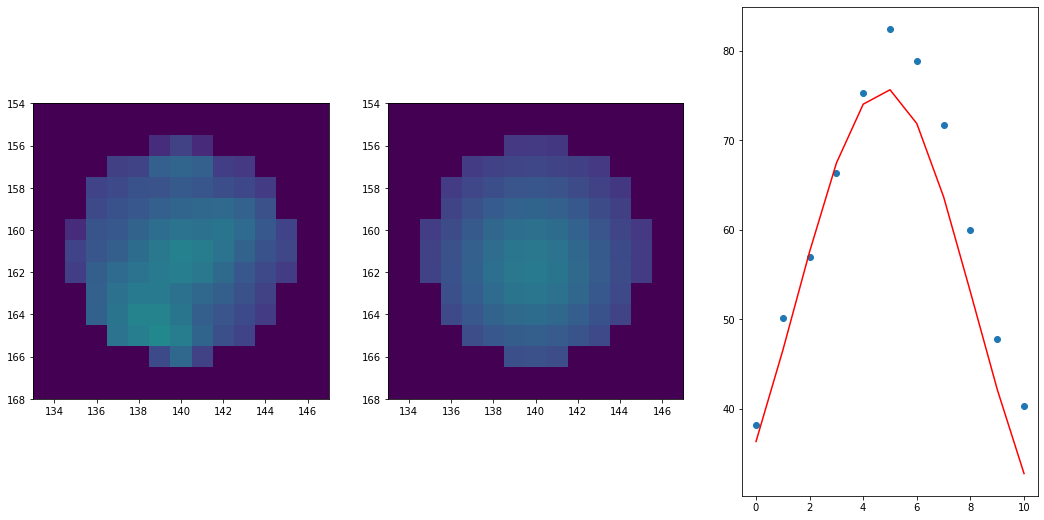

Fitting spot 21 (2/14):   0%|          | 0/58300 [00:00<?, ? fev/s]

----------------------------
Image max = 188.35, spot max = 94.22
Neighbours idx = [29]
Spot idx = 21
Chisquare = 2484.54, p = 0.0000
KS stat = 0.17, p = 0.0000
R_sq = 0.58, Adj. R-sq = 0.57
RMSE = 12.82
NRMSE = 0.29
F_NRMSE = 0.86
-------------------
Sigmas fit = (1.74, 4.36, 3.69)
A fit = 68.60, B fit = 0.00
Total integral result, fit sum, observed sum = 25882.89, 26091.24, 8471.96
Foregroung integral value: 25882.89
----------------------------


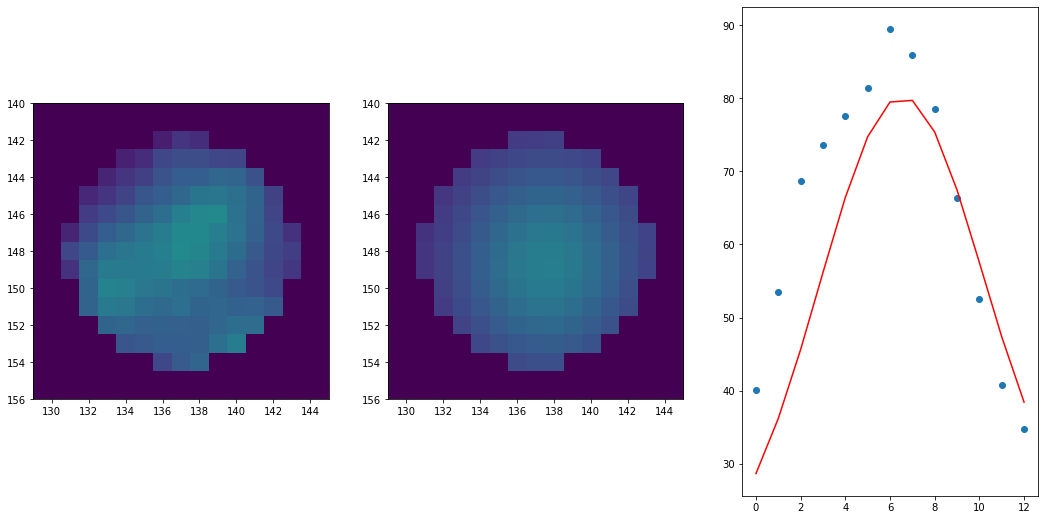

Fitting spot 11 (3/14):   0%|          | 0/39100 [00:00<?, ? fev/s]

----------------------------
Image max = 188.35, spot max = 94.22
Neighbours idx = [29]
Spot idx = 11
Chisquare = 1208.24, p = 0.0000
KS stat = 0.05, p = 0.6865
R_sq = 0.55, Adj. R-sq = 0.54
RMSE = 12.22
NRMSE = 0.23
F_NRMSE = 0.89
-------------------
Sigmas fit = (1.79, 3.76, 2.95)
A fit = 73.35, B fit = 0.00
Total integral result, fit sum, observed sum = 19671.98, 21233.03, 8471.96
Foregroung integral value: 19671.98
----------------------------


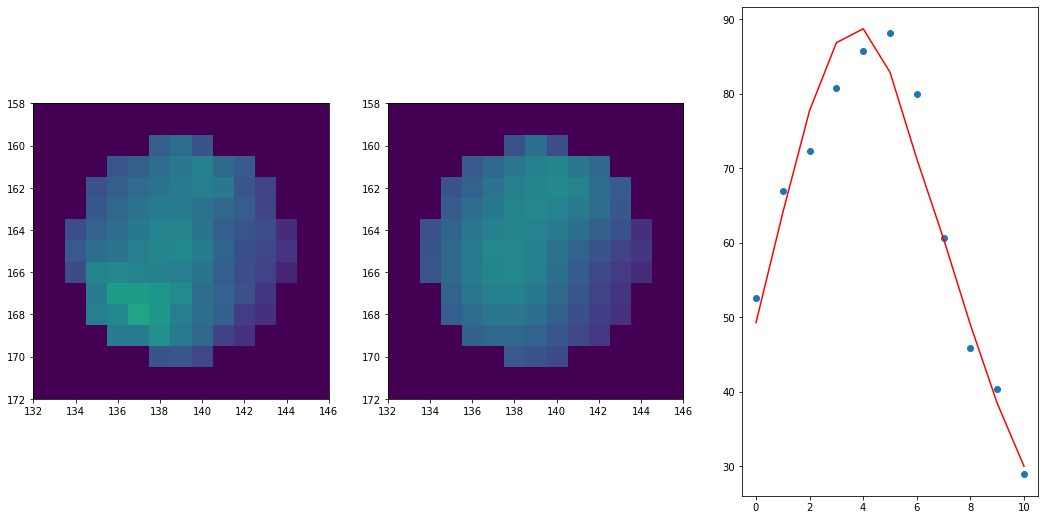

Fitting spot 25 (4/14):   0%|          | 0/58300 [00:00<?, ? fev/s]

----------------------------
Image max = 188.35, spot max = 94.22
Neighbours idx = [29]
Spot idx = 25
Chisquare = 1343.48, p = 0.0000
KS stat = 0.22, p = 0.0000
R_sq = 0.80, Adj. R-sq = 0.80
RMSE = 8.98
NRMSE = 0.25
F_NRMSE = 0.88
-------------------
Sigmas fit = (1.74, 3.88, 3.15)
A fit = 66.17, B fit = 0.00
Total integral result, fit sum, observed sum = 19047.89, 21790.39, 8471.96
Foregroung integral value: 19047.89
----------------------------


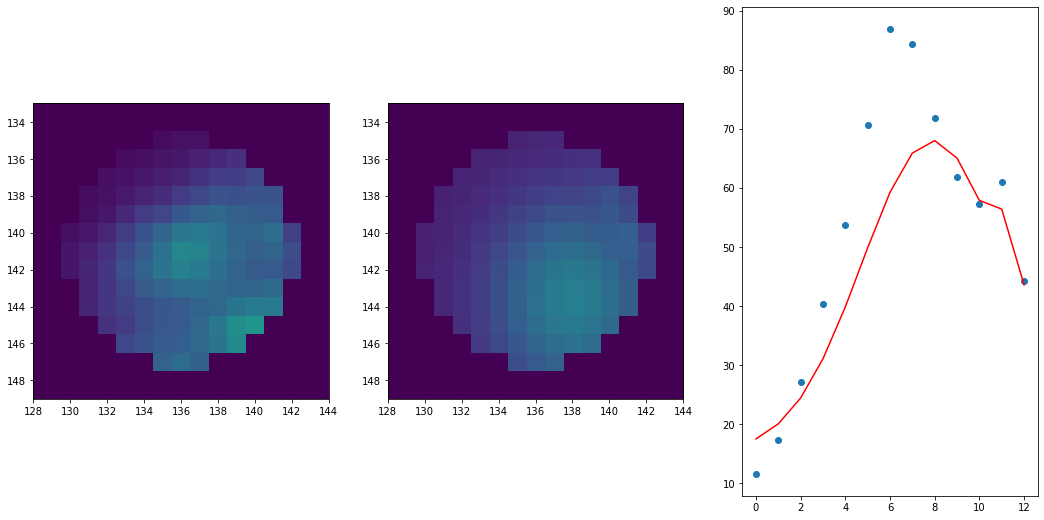

Fitting spot 1 (5/14):   0%|          | 0/58300 [00:00<?, ? fev/s]

----------------------------
Image max = 188.35, spot max = 94.22
Neighbours idx = [29]
Spot idx = 1
Chisquare = 1100.36, p = 0.0000
KS stat = 0.07, p = 0.1472
R_sq = 0.60, Adj. R-sq = 0.60
RMSE = 11.00
NRMSE = 0.16
F_NRMSE = 0.92
-------------------
Sigmas fit = (1.45, 5.31, 5.85)
A fit = 77.08, B fit = 0.00
Total integral result, fit sum, observed sum = 46806.14, 40492.82, 8471.96
Foregroung integral value: 46806.14
----------------------------


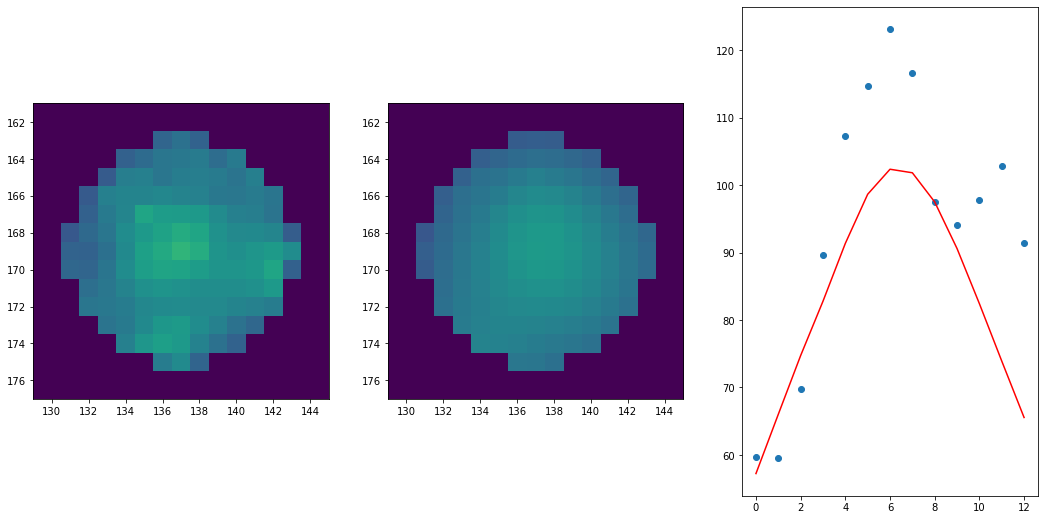

Fitting spot 5 (6/14):   0%|          | 0/39100 [00:00<?, ? fev/s]

----------------------------
Image max = 188.35, spot max = 94.22
Neighbours idx = [29]
Spot idx = 5
Chisquare = 383.11, p = 0.4744
KS stat = 0.07, p = 0.3091
R_sq = 0.78, Adj. R-sq = 0.78
RMSE = 7.51
NRMSE = 0.12
F_NRMSE = 0.94
-------------------
Sigmas fit = (2.24, 2.90, 2.85)
A fit = 72.62, B fit = 11.99
Total integral result, fit sum, observed sum = 31500.72, 23948.62, 8471.96
Foregroung integral value: 18143.59
----------------------------


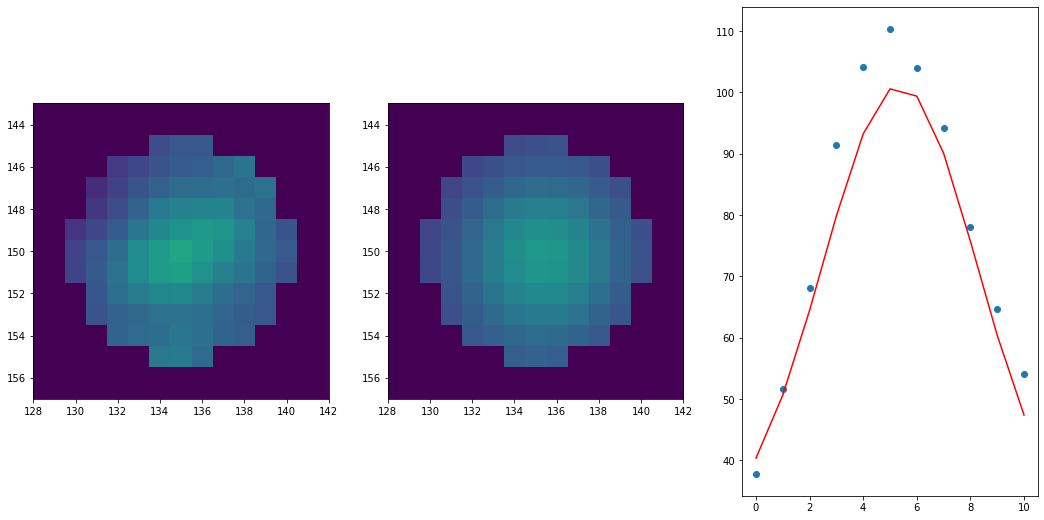

Fitting spot 18 (7/14):   0%|          | 0/39100 [00:00<?, ? fev/s]

----------------------------
Image max = 188.35, spot max = 94.22
Neighbours idx = [29]
Spot idx = 18
Chisquare = 432.81, p = 0.0370
KS stat = 0.07, p = 0.3533
R_sq = 0.86, Adj. R-sq = 0.86
RMSE = 7.33
NRMSE = 0.15
F_NRMSE = 0.93
-------------------
Sigmas fit = (1.26, 3.87, 3.65)
A fit = 58.49, B fit = 0.00
Total integral result, fit sum, observed sum = 14046.14, 19629.93, 8471.96
Foregroung integral value: 14046.14
----------------------------


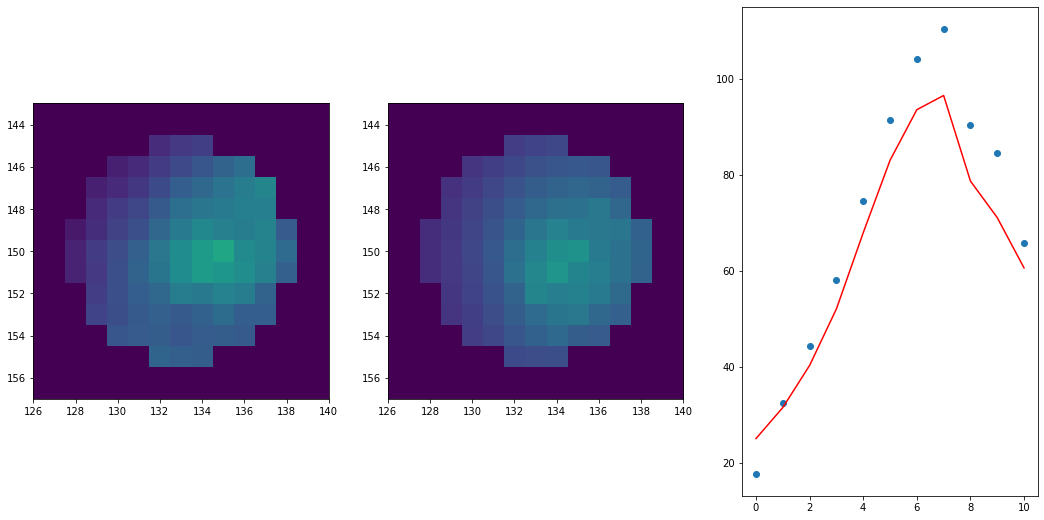

Fitting spot 19 (8/14):   0%|          | 0/58300 [00:00<?, ? fev/s]

----------------------------
Image max = 188.35, spot max = 94.22
Neighbours idx = [29]
Spot idx = 19
Chisquare = 1394.88, p = 0.0000
KS stat = 0.12, p = 0.0003
R_sq = 0.57, Adj. R-sq = 0.56
RMSE = 11.87
NRMSE = 0.25
F_NRMSE = 0.88
-------------------
Sigmas fit = (1.90, 1.96, 1.76)
A fit = 57.40, B fit = 0.00
Total integral result, fit sum, observed sum = 5068.92, 29674.61, 8471.96
Foregroung integral value: 5068.92
----------------------------


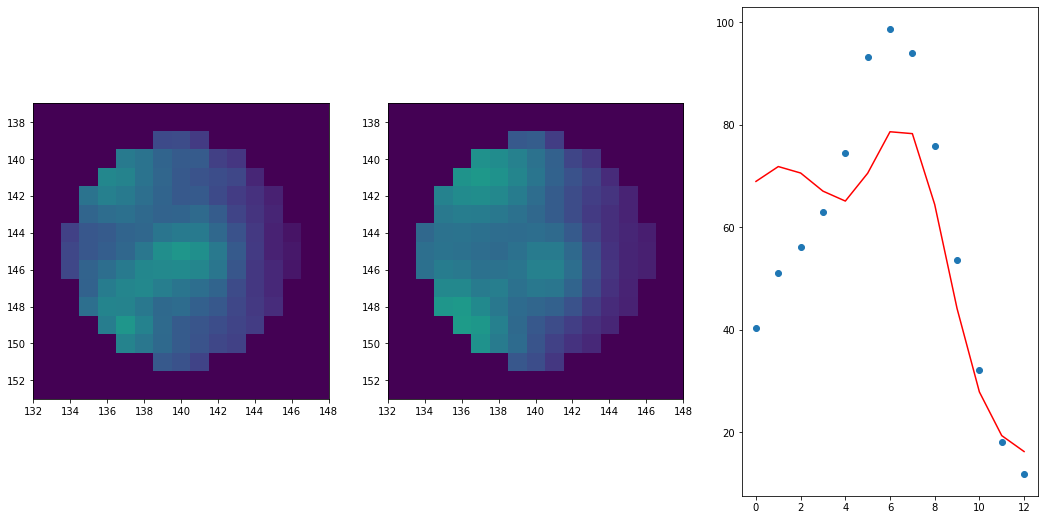

Fitting spot 0 (9/14):   0%|          | 0/39100 [00:00<?, ? fev/s]

----------------------------
Image max = 188.35, spot max = 94.22
Neighbours idx = [29]
Spot idx = 0
Chisquare = 1965.49, p = 0.0000
KS stat = 0.07, p = 0.3533
R_sq = -0.43, Adj. R-sq = -0.46
RMSE = 21.16
NRMSE = 0.26
F_NRMSE = 0.87
-------------------
Sigmas fit = (0.70, 0.01, 1.34)
A fit = 84.74, B fit = 11.33
Total integral result, fit sum, observed sum = 15.27, 31424.26, 8471.96
Foregroung integral value: 9.56
----------------------------


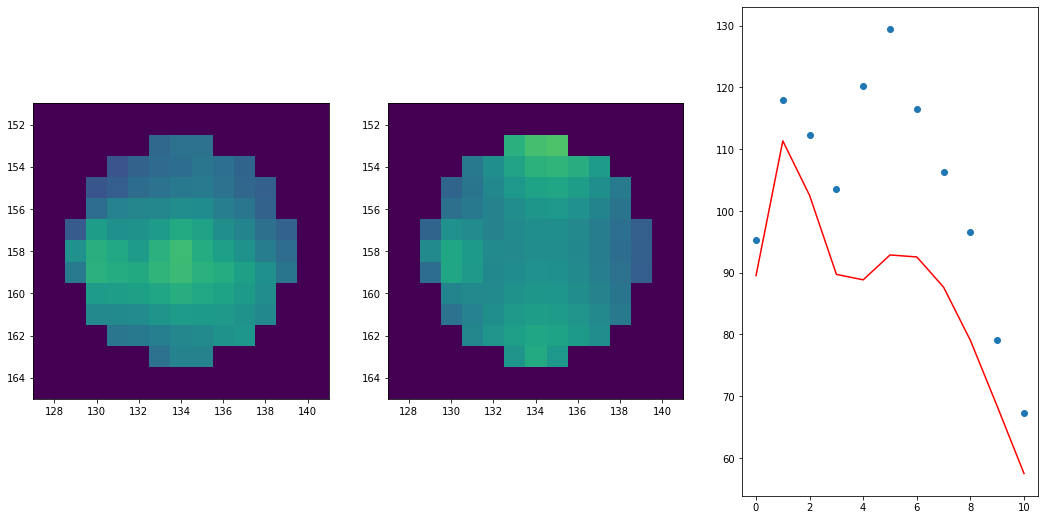

Fitting spot 6 (10/14):   0%|          | 0/58300 [00:00<?, ? fev/s]

----------------------------
Image max = 188.35, spot max = 94.22
Neighbours idx = [29]
Spot idx = 6
Chisquare = 892.59, p = 0.0000
KS stat = 0.04, p = 0.7551
R_sq = 0.78, Adj. R-sq = 0.77
RMSE = 9.51
NRMSE = 0.15
F_NRMSE = 0.92
-------------------
Sigmas fit = (0.94, 2.91, 2.78)
A fit = 52.14, B fit = 0.29
Total integral result, fit sum, observed sum = 5479.03, 35864.12, 8471.96
Foregroung integral value: 5346.90
----------------------------


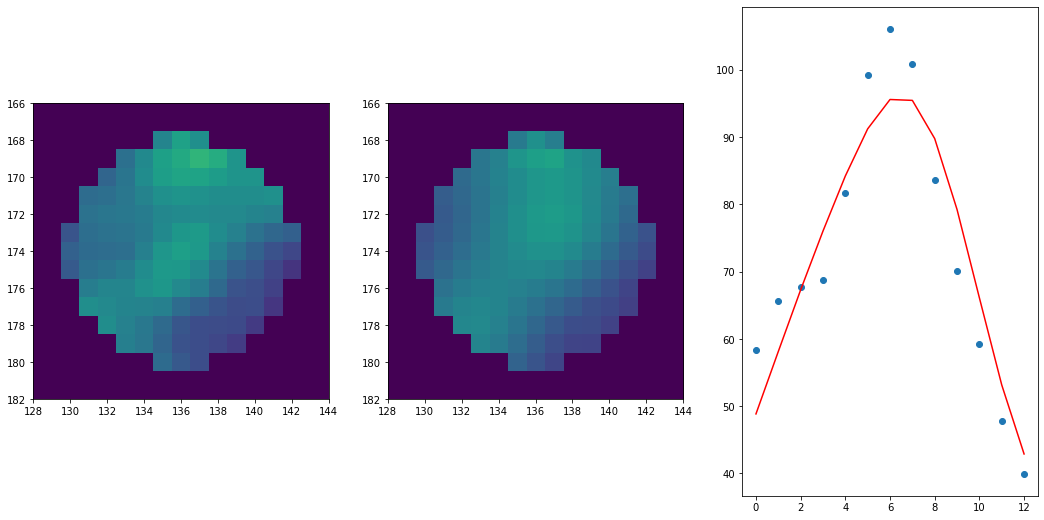

Fitting spot 15 (11/14):   0%|          | 0/58300 [00:00<?, ? fev/s]

----------------------------
Image max = 188.35, spot max = 94.22
Neighbours idx = [29]
Spot idx = 15
Chisquare = 3519.19, p = 0.0000
KS stat = 0.16, p = 0.0000
R_sq = 0.35, Adj. R-sq = 0.35
RMSE = 21.37
NRMSE = 0.43
F_NRMSE = 0.79
-------------------
Sigmas fit = (0.55, 4.78, 1.55)
A fit = 67.09, B fit = 0.00
Total integral result, fit sum, observed sum = 5479.03, 36506.72, 8471.96
Foregroung integral value: 5346.90
----------------------------


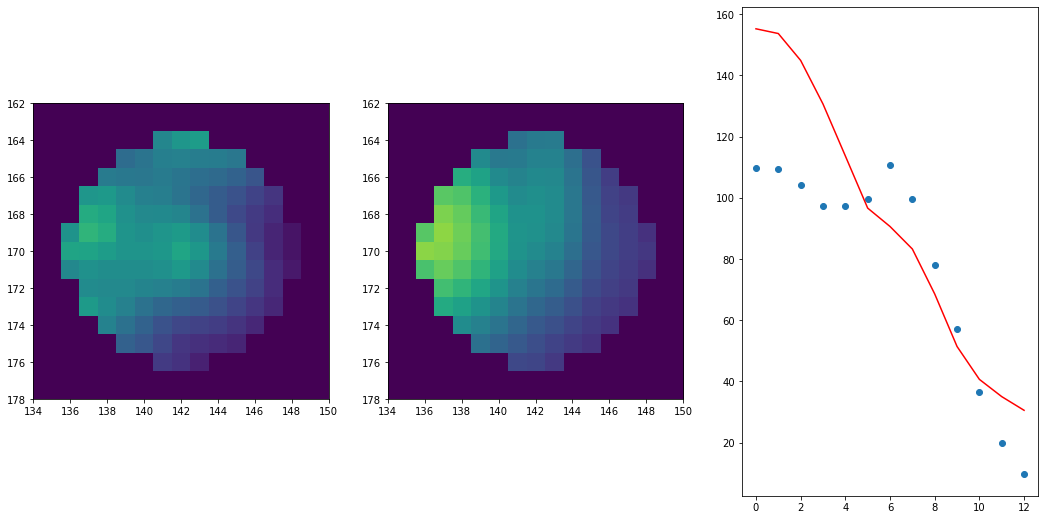

Fitting spot 14 (12/14):   0%|          | 0/109100 [00:00<?, ? fev/s]

----------------------------
Image max = 188.35, spot max = 94.22
Neighbours idx = [29]
Spot idx = 14
Chisquare = 9046.12, p = 0.0000
KS stat = 0.22, p = 0.0000
R_sq = -0.07, Adj. R-sq = -0.08
RMSE = 21.93
NRMSE = 0.48
F_NRMSE = 0.76
-------------------
Sigmas fit = (1.45, 4.21, -1.70)
A fit = 40.17, B fit = 0.00
Total integral result, fit sum, observed sum = 5479.03, 59921.29, 8471.96
Foregroung integral value: 5346.90
----------------------------


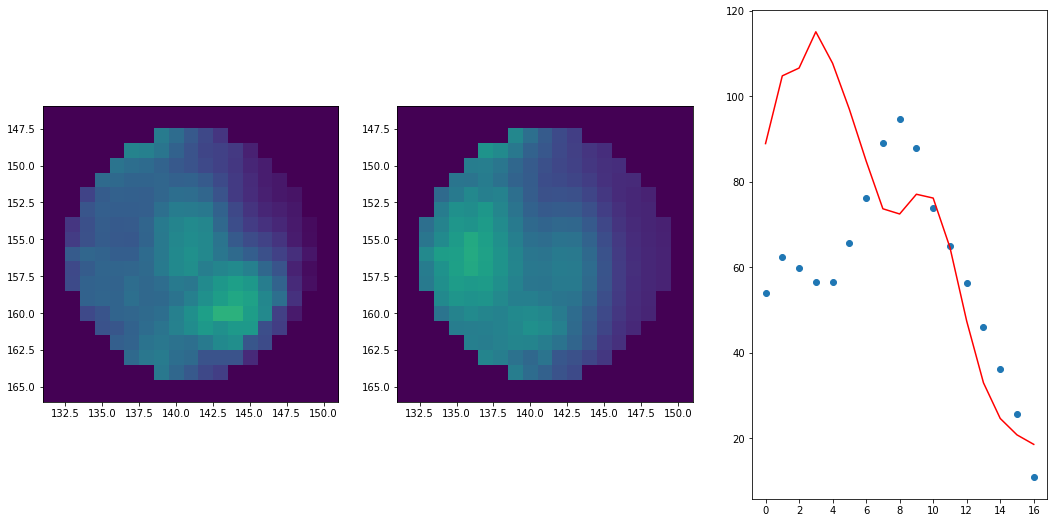

Fitting spot 16 (13/14):   0%|          | 0/187700 [00:00<?, ? fev/s]

----------------------------
Image max = 188.35, spot max = 94.22
Neighbours idx = [29]
Spot idx = 16
Chisquare = 7894.11, p = 0.0000
KS stat = 0.25, p = 0.0000
R_sq = 0.69, Adj. R-sq = 0.69
RMSE = 15.70
NRMSE = 0.38
F_NRMSE = 0.81
-------------------
Sigmas fit = (1.53, 3.41, 1.65)
A fit = 68.27, B fit = 0.00
Total integral result, fit sum, observed sum = 7942.12, 92855.68, 8471.96
Foregroung integral value: 7942.12
----------------------------


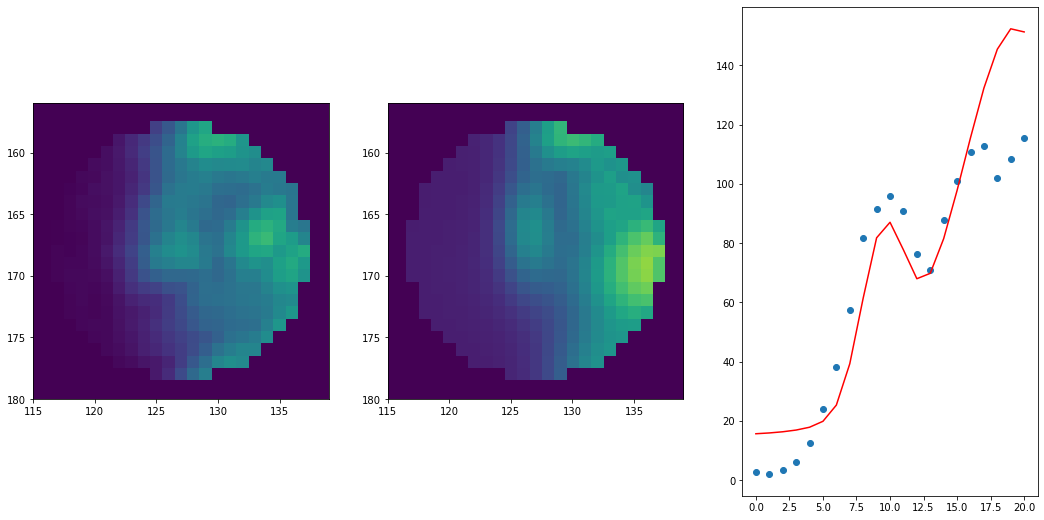

Fitting spot 3 (14/14):   0%|          | 0/187700 [00:00<?, ? fev/s]

----------------------------
Image max = 188.35, spot max = 94.22
Neighbours idx = [29]
Spot idx = 3
Chisquare = 8730.69, p = 0.0000
KS stat = 0.26, p = 0.0000
R_sq = 0.72, Adj. R-sq = 0.72
RMSE = 15.47
NRMSE = 0.37
F_NRMSE = 0.82
-------------------
Sigmas fit = (1.39, 2.68, 2.45)
A fit = 114.93, B fit = 0.00
Total integral result, fit sum, observed sum = 14180.97, 89791.08, 8471.96
Foregroung integral value: 14180.97
----------------------------


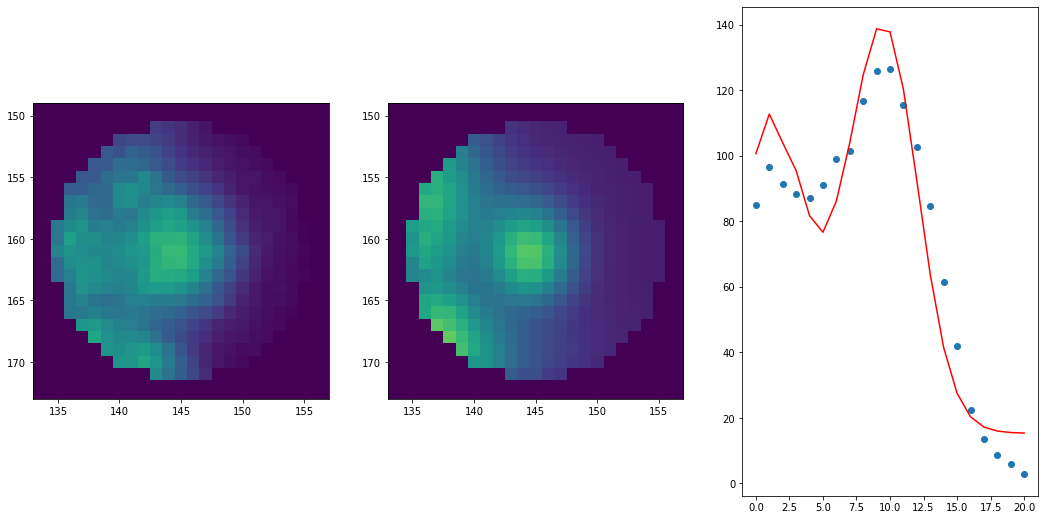

Spots idx to be removed = [14, 15]


In [72]:
import ipdb

bad_fit_idx = fit_again_idx.copy()
num_spots = len(df_intersect_fit_again)
for count, (obj_id, s) in enumerate(df_intersect_fit_again.index):
    neigh_idx = df_intersect_fit_again.loc[(obj_id, s)]['neigh_idx']
    good_neigh_idx = [s for s in neigh_idx if s not in bad_fit_idx]
    
    z_s, y_s, x_s = np.nonzero(spots_4D_lab[s])
    
    # Constants from good neigh idx
    const_coeffs = [fitted_coeffs[good_s] for good_s in good_neigh_idx]
    const = model.compute_const(z_s, y_s, x_s, const_coeffs)
    
    # Bounds and initial guess
    num_spots_s = 1
    zyx_centers = [tuple(spots_centers[s])]
    spots_radii_pxl_s = [spots_radii_pxl[s]]
    spots_max_A_s = [spots_max_As[s]]
    spots_Bs_guess = [Bs_guess[s]]
    bounds, init_guess_s = model.get_bounds_init_guess(
                                                 num_spots_s, num_coeffs,
                                                 zyx_centers, spots_radii_pxl_s,
                                                 spots_max_A_s, spots_Bs_guess
    )
    
    # Fit with constants
    data_s = img[z_s, y_s, x_s]
    model.pbar = tqdm(desc=f'Fitting spot {s} ({count+1}/{num_spots})',
                          total=100*len(z_s), unit=' fev',
                          position=0, leave=True)
    leastsq_result = least_squares(model.residuals, init_guess_s,
                                   args=(data_s, z_s, y_s, x_s, num_spots_s,
                                         num_coeffs),
                                   # jac=model.jac_gauss3D,
                                   kwargs={'const': const},
                                   loss='linear', f_scale=0.1,
                                   bounds=bounds)
    
    # Goodness of fit
    ddof = num_coeffs
    s_fit_data =  model._gauss3D(z_s, y_s, x_s,
                                 leastsq_result.x,
                                 obj_num_spots, num_coeffs, const)
    (chisq, p_chisq, R_sq, RMSE, 
     ks, p_ks, adj_Rsq, 
     NRMSE, F_NRMSE) = model.goodness_of_fit(data_s, s_fit_data, ddof)
    
    # Initial guess
    (z0_guess, y0_guess, x0_guess,
    sz_guess, sy_guess, sx_guess,
    A_guess, B_guess) = init_guess_li[s]

    # Fitted coeffs 
    (z0_fit, y0_fit, x0_fit,
    sz_fit, sy_fit, sx_fit,
    A_fit, B_fit) = leastsq_result.x
    
    
    if F_NRMSE > 0.8:
        bad_fit_idx.remove(s)
        
        zyx_centers = np.abs(np.array([z0_fit, y0_fit, x0_fit]))
        zyx_sigmas = np.abs(np.array([sz_fit, sy_fit, sx_fit]))

        I_tot, I_foregr = model_temp().integrate(
                        zyx_centers, zyx_sigmas, A_fit, B_fit, 
                        lower_bounds=None, upper_bounds=None
        )

        df_spotQUANT = model_temp().store_metrics_good_spots(
                                 df_spotQUANT, obj_id, s,
                                 leastsq_result.x, I_tot, I_foregr
        )
   
    
    # Testing
    print('----------------------------')
    print(f'Image max = {img_max:.2f}, spot max = {s_data.max():.2f}')
    print(f'Neighbours idx = {obj_s_idxs}')
    print('Spot idx =', s)
    print(f'Chisquare = {chisq:.2f}, p = {p_chisq:.4f}')
    print(f'KS stat = {ks:.2f}, p = {p_ks:.4f}')
    print(f'R_sq = {R_sq:.2f}, Adj. R-sq = {adj_Rsq:.2f}')
    print(f'RMSE = {RMSE:.2f}')
    print(f'NRMSE = {NRMSE:.2f}')
    print(f'F_NRMSE = {F_NRMSE:.2f}')
    print('-------------------')
    print(f'Sigmas fit = ({sz_fit:.2f}, {sy_fit:.2f}, {sx_fit:.2f})')
    print(f'A fit = {A_fit:.2f}, B fit = {B_fit:.2f}')
    print(f'Total integral result, fit sum, observed sum = {I_tot:.2f}, {s_fit_data.sum():.2f}, {s_data.sum():.2f}')
    print(f'Foregroung integral value: {I_foregr:.2f}')
    print('----------------------------')


    fig, ax = plt.subplots(1,3, figsize=[18,9])

    img_s = np.zeros_like(img)
    img_s[z_s, y_s, x_s] = data_s

    img_s_fit = np.zeros_like(img)
    img_s_fit[z_s, y_s, x_s] = s_fit_data

    y_intens = img_s.max(axis=0)[int(y0_guess)]
    y_intens = y_intens[y_intens!=0]

    y_gauss = img_s_fit.max(axis=0)[int(y0_guess)]
    y_gauss = y_gauss[y_gauss!=0]

    ax[0].imshow(img_s.max(axis=0), vmax=img_max)
    ax[1].imshow(img_s_fit.max(axis=0), vmax=img_max)
    ax[2].scatter(range(len(y_intens)), y_intens)
    ax[2].plot(range(len(y_gauss)), y_gauss, c='r')

    l = x_s.min()
    b = y_s.min()

    r = x_s.max()
    t = y_s.max()

    ax[0].set_xlim((l-2, r+2))
    ax[0].set_ylim((t+2, b-2))

    ax[1].set_xlim((l-2, r+2))
    ax[1].set_ylim((t+2, b-2))


    plt.show()

    # ipdb.set_trace()

print(f'Spots idx to be removed = {bad_fit_idx}')

In [73]:
df_spotQUANT = (df_spotQUANT
                .drop(['intersecting_idx', 'neigh_idx'], axis=1)
                .reset_index()
                .set_index('s')
                .drop(bad_fit_idx)
               )

,obj_id,id,num_intersect,num_neigh,z0_fit,y0_fit,x0_fit,sigma_z_fit,sigma_y_fit,sigma_x_fit,...,B_fit,I_tot,I_foregr,chisq,p_chisq,KS_stat,p_KS,RMSE,NRMSE,F_NRMSE
s,,,,,,,,,,,,,,,,,,,,,
49,1,50,1,1,10.500000,151.184079,172.155481,1.198449,2.013743,2.433355,...,8.668251e+00,5522.406145,2456.076986,119.597238,1.000000e+00,0.110638,0.112662,2.878104,0.163213,0.918574
17,8,18,1,2,22.648868,162.426677,216.169380,1.353411,3.352282,2.606738,...,6.970148e+00,23316.256145,18350.701198,543.267908,8.169956e-01,0.099485,0.006210,5.262617,0.143954,0.928147
34,7,35,1,1,20.500000,208.262277,167.956902,1.505623,2.453101,3.532332,...,1.453912e-09,13151.549246,13151.549244,111.738737,1.000000e+00,0.055319,0.865810,3.980498,0.118067,0.941035
35,4,36,1,4,12.516633,185.502023,202.434559,1.742937,3.426409,2.870178,...,4.459958e+00,16788.525388,12183.641821,138.141521,9.999992e-01,0.102128,0.172463,4.310000,0.136902,0.931656
36,15,37,1,1,27.029966,156.867402,191.399906,1.215137,2.201661,2.786218,...,5.338105e+00,10147.709534,7750.885371,123.566548,1.000000e+00,0.038298,0.995468,4.078024,0.131656,0.934267
27,5,28,1,27,17.695655,191.679089,136.668060,1.698149,2.551874,2.094112,...,1.516201e+01,15821.995221,7533.991062,681.777951,3.272040e-19,0.153453,0.000196,7.206742,0.219494,0.890692
38,13,39,1,1,27.340099,149.821405,169.885797,1.118247,2.133170,3.263187,...,6.357076e+00,10592.318933,7611.601427,134.199159,9.999998e-01,0.042553,0.983903,4.074468,0.136117,0.932047
39,3,40,1,5,12.528492,155.992746,203.744275,1.488750,1.958633,2.730430,...,1.033232e+01,10398.162885,5442.955484,87.553265,1.000000e+00,0.076596,0.496634,3.068217,0.107633,0.946235
33,11,34,1,1,25.309308,141.535621,190.212448,1.106870,2.333077,3.090967,...,6.506113e+00,12056.759253,8928.519835,50.467923,1.000000e+00,0.042553,0.983903,2.569746,0.073488,0.963273


In [76]:
df_spotQUANT['I_foregr'] = (df_spotQUANT['I_foregr']
                            /df_spotQUANT['I_foregr'].max())
df_spotQUANT.loc[5]

obj_id               5.000000
id                   6.000000
num_intersect        8.000000
num_neigh           27.000000
z0_fit              18.205122
y0_fit             150.160590
x0_fit             135.381287
sigma_z_fit          2.242163
sigma_y_fit          2.898615
sigma_x_fit          2.846787
A_fit               72.621306
B_fit               11.985121
I_tot            31500.723053
I_foregr             0.387633
chisq              383.108640
p_chisq              0.474411
KS_stat              0.069054
p_KS                 0.309106
RMSE                 7.514823
NRMSE                0.122692
F_NRMSE              0.938731
Name: 5, dtype: float64